<h1><center>Прогноз стоимости автомобилей</center></h1>

# Описание исследования

Заказчиком в данном проекте является сервис по продаже автомобилей с пробегом. Данный сервис разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.


# Цель проекта

С помощью машинного обучения необходимо наилучшим образом предсказывать стоимость автомобиля.

# Задачи исследования

Разработать модель машинного обучения для расчета стоимости автомобиля по его признакам. Выбрать лучшую модель для расчета стоимости автомобиля по его признакам, исходя из критериев:
- качество предсказания;
- скорость предсказания;
- время обучения.


# Исходные данные

В наличии csv-файл с историческими данными: технические характеристики, комплектации и цены автомобилей.

Название и описание столбцов:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Данное исследование разделим на несколько частей.**

**Часть 1. Изучение общей информации**

1. Изученение файлов с данными, получение общей информации, загрузка библиотек.

**Часть 2. Предобработка данных**

1. Переименование названий столбцов.

2. Обработка пропусков.

3. Обработка аномалий.

4. Обработка дубликатов.

**Часть 3. Исследовательский и корреляционный анализ данных**

**Часть 4. Обучение моделей**

1. Модель LightGBM

2. Модель LinearRegression

3. Модель DesisionTreeRegressor

**Часть 5. Анализ моделей**

**Вывод**



## Часть 1. Изучение общей информации

## Изученение файлов с данными, получение общей информации, загрузка библиотек

In [ ]:
# импорт библиотек
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats as st
from datetime import datetime
from time import time

# загружаем необходимые инструменты
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures
)

# загружаем инструмент для автоподбора гиперпараметров
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные метрики
from sklearn.metrics import mean_squared_error as mse, confusion_matrix, make_scorer, r2_score

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
!pip install --user -U scikit-learn==0.24.1 -q

In [ ]:
# улучшение чёткости изображения
%config InlineBackend.figure_format = 'retina'

# настройка шрифтов заголовков и подписей для графиков
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)
plt.style.use('seaborn-bright')

Для начала последовательно считаем исходный csv-файл и сохраним его в переменной df. Затем сделаем предварительный просмотр данных методом sample(10) и с помощью метода info() узнаем основные характеристики исходного датасета.

В ходе предварительной загрузки выяснилось, что 3 столбца с датой и временем ('DateCrawled', 'DateCreated', 'LastSeen') считываются с типом object, а не datetime. Исправим это сразу на этапе загрузки, передав список с этими столбцами параметру parse_dates.

In [ ]:
# сохранение данных в переменной df
df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
# просмотр 10 случайных строк датафрейма
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
335699,2016-03-19 11:44:04,350,small,2000,manual,60,ka,150000,4,petrol,ford,NaN,2016-03-19,0,66787,2016-03-20 13:15:45
23762,2016-03-17 17:57:28,18890,coupe,2012,manual,170,c_klasse,150000,6,gasoline,mercedes_benz,no,2016-03-17,0,88085,2016-04-07 04:45:00
245422,2016-03-21 11:54:36,900,sedan,1998,manual,90,NaN,150000,10,petrol,ford,yes,2016-03-21,0,34454,2016-04-06 05:45:56
292111,2016-03-19 09:57:35,3990,wagon,2007,manual,109,focus,150000,4,gasoline,ford,no,2016-03-19,0,88097,2016-04-06 10:44:40
230212,2016-04-04 18:45:46,900,small,1996,manual,60,fiesta,150000,2,petrol,ford,NaN,2016-04-04,0,66809,2016-04-06 20:46:37
258970,2016-03-05 21:25:23,0,bus,1998,manual,90,scenic,150000,1,petrol,renault,yes,2016-03-05,0,56637,2016-04-05 15:47:57
341803,2016-03-08 14:54:09,900,NaN,2017,manual,60,lupo,150000,6,NaN,volkswagen,no,2016-03-08,0,45896,2016-03-29 22:16:29
162745,2016-03-11 12:38:42,3500,small,2004,manual,122,c2,150000,10,petrol,citroen,no,2016-03-11,0,67691,2016-03-12 01:44:26
231264,2016-03-08 18:52:15,1000,other,1997,manual,0,caddy,150000,4,petrol,volkswagen,yes,2016-03-08,0,16562,2016-03-22 05:17:42
309931,2016-03-25 18:42:50,9900,bus,2009,manual,140,zafira,80000,5,petrol,opel,no,2016-03-25,0,89415,2016-04-07 00:16:19


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

<font size="4"><b>Выводы по первоначальному обзору данных датафрейма df</b></font>

- В датафрейме 354369 строк и 16 столбцов.
- Названия столбцов написаны "верблюжьим" регистром. Нужно привести его в "змеиный".
- Проверить все столбцы со строковым типом данных на неявные дубликаты и всю таблицу на явные.
- Есть пропуски данных в 5 столбцах: VehicleType, Gearbox, Model, FuelType, Repaired.
- Столбцы с данными формата datetime были сразу переданы параметру parse_dates и поэтому верно загружены. В остальных столбцах типы данных преобразовывать не надо.

Посмотрим на данные типа datetime и узнаем за какой диапазон времени имеются данные.

In [ ]:
# список столбцов с типом данных datetime
dt_features = ['DateCrawled', 'DateCreated', 'LastSeen']

for d in dt_features:
    print(f"Признак {d}: Даты от {df['DateCrawled'].min()} до {df['DateCrawled'].max()}")

Признак DateCrawled: Даты от 2016-03-05 14:06:22 до 2016-04-07 14:36:58
Признак DateCreated: Даты от 2016-03-05 14:06:22 до 2016-04-07 14:36:58
Признак LastSeen: Даты от 2016-03-05 14:06:22 до 2016-04-07 14:36:58


**Диапазон дат и времени по всем признакам типа datetime совпадает, т.е. в наличии имеются данные по объявлениям, созданным в марте и апреле 2016 года. В этом же диапазоне времени они были скачаны.**

Далее изучим данные по всем количественным и качественным признакам.

In [ ]:
# просмотр количественных и строковых данных
temp = df.copy()

temp.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
# обзор данных
col_list = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'NumberOfPictures', 'PostalCode']

for col in col_list:
    print('-'* 25)
    print(col, temp[col].sort_values().unique())
    print(col,': кол-во NaN',temp[col].isna().sum(),
        ', процент NaN', round(temp[col].isna().mean()*100,2),'%')

-------------------------
Price [    0     1     2 ... 19998 19999 20000]
Price : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
VehicleType ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
VehicleType : кол-во NaN 37490 , процент NaN 10.58 %
-------------------------
RegistrationYear [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900

<font size="4"><b>Выявленные аномалии и наблюдения при обзоре данных </b></font>

по столбцам:

1. 'Price' есть данные с нулевой ценой, а также 1, 2 евро и т.п., что также является аномалией. Необходимо выяснить количество таких аномальных данных.
2. 'VehicleType' есть пропуски (10.58%), которые можно заменить уже присутствующим в данных значением 'other',
3. 'RegistrationYear' есть также явно аномальные данные: годы регистрации от 1000 до 1910, а также от 2066 до 9999. Учитывая то, что как выяснилось в исходных данных имеются только объявления созданные в 2016 году, то годы регистрации после 2016 также можно считать артефактом. Необходимо выяснить количество таких данных.
4. 'Gearbox' есть пропущенные значения (5.6%), которые можно заменить на 'unknown',
5. 'Power' присутствуют данные с мощностью двигателя равной нулю. Помимо этого присутствуют и аномально высокие значения вплоть до 20 тыс. л.с. Необходимо изучить эти аномалии.
6. 'Model' присутствует 2 названия с разным написанием, но одинаковым смыслом - это 'range_rover' и 'rangerover'. Нужно их привести к одинаковому написанию. Заменим 'rangerover' на 'range_rover'. Также есть пропуски (5.56%), которые можно заменить значением 'other'.
7. 'Kilometer' присутствуют автомобили с пробегом от 5 тыс. км до 150 тыс. км. Аномалий не выявлено.
8. 'RegistrationMonth' есть данные с номером месяца 0.  
9. 'FuelType' есть 9.28 % пропусков, которые можно заменить уже присутствующим в данных значением 'other'
10. 'Brand' пропусков и аномалий нет,
11. 'Repaired' есть пропущенные значения (20.08%), которые можно заменить на 'unknown',
12. 'NumberOfPictures' количество объявлений равно нулю для всех объявлений. Возможно произошел сбой при выгрузке информации о количестве фотографий, т.к. вызывает большое сомнение отсутствие фотографий к объявлениям о продаже. Данный столбец неинформативен для моделирования и его стоит удалить.
13. 'PostalCode' пропусков нет.

<font size="4">Столбец Price</font>

Значения цены равные нулю точно являются артефактом, возникшим в результате технического сбоя при подготовке данных. Посмотрим на количество и долю этих данных.

In [ ]:
# расчет количества и доли строк со значением цены равной нулю
print(f"Количество строк со значением цены равной нулю: {len(df.query('Price == 0'))}")
print(f"Доля строк со значением цены равной нулю: {len(df.query('Price == 0')) / len(df['Price']):.1%}")

Количество строк со значением цены равной нулю: 10772
Доля строк со значением цены равной нулю: 3.0%


Аномальные значения содержатся в 3% всех строк. Данный признак является целевым, поэтому особенно важно качество данных по нему. 3% в общем объеме - это небольшое значение, поэтому эти строки можно удалить.

Посмотрим также на данные со значением цены от 0 до 50 евро. Посмотрим на модели машин, которые имеют такую цену и оценим долю этих значений.

In [ ]:
# получение уникальных названий моделей машин с ценой в диапазоне от 0 до 50 евро
check = df.query('Price > 0 and Price < 50')
check['Model'].value_counts()

other      139
golf       108
3er         87
corsa       60
polo        56
          ... 
glk          1
90           1
rio          1
c1           1
touareg      1
Name: Model, Length: 150, dtype: int64

In [ ]:
# расчет количества и доли строк со значением цены в диапазоне от 0 до 50 евро
print(f"Количество строк со значением цены больше 0 и ниже 50 евро: {len(check['Price'])}")
print(f"Доля строк со значением цены больше 0 и ниже 50 евро: {len(check['Price']) / len(df['Price']):.1%}")

Количество строк со значением цены больше 0 и ниже 50 евро: 1651
Доля строк со значением цены больше 0 и ниже 50 евро: 0.5%


Как выяснилось таких значений немного (0.5%). Большинство моделей неизвестны, а второй по популярности моделью является Volkswagen Golf, который выпускается с 1974 года и вполне мог стоить до 50 евро в 2016 году, поэтому оставляем эти данные.

<font size="4">Столбец RegistrationYear</font>

Учитывая, что первый автомобиль был создан в 1886 г., годы регистрации автомобиля до 1910 являются точно артефактами. Кроме того, годы после 2016 (даты скачивания последнего обявления) также не отражают реальность. Посмотрим на количество и долю таких значений.

In [ ]:
# расчет количества и доли строк со значением года регистрации до 1910 и после 2016
print(f"Количество строк со значением цены равной нулю: \
        {len(df.query('RegistrationYear < 1910 or RegistrationYear > 2016'))}")
print(f"Доля строк со значением цены равной нулю: \
      {len(df.query('RegistrationYear < 1910 or RegistrationYear > 2016')) / len(df['RegistrationYear']):.1%}")

Количество строк со значением цены равной нулю: 14596
Доля строк со значением цены равной нулю:       4.1%


Доля строк с аномальными значениями относительно общего объема данных невелика и равна 4.1%. Восстановить эти данные не представляется возможным, поэтому можно удалить эти данные.

<font size="4">Столбец Power</font>

При обзоре было выявлено, что в данных имеются машины мощностью 0 л.с., а также мощностью до 20 тыс.л.с. Посмотрим количество таких аномальных значений.
Самым мощным автомобилем является Devel Sixteen с мощностью 5000 л.с. Хотя такой марки нет в перечне исходных данных, будем использовать значение 5000 л.с., чтобы отсечь "потолок" по мощности среди имеющихся даннных.

In [ ]:
# расчет количества и доли строк со значением мощности равной 0 и выше 5000 л.с.
print(f"Количество строк со значением мощности равной 0 и выше 5000 л.с.: \
                {len(df.query('Power == 0 or Power > 5000'))}")
print(f"Доля строк со значением мощности равной 0 и выше 5000 л.с.: \
      {len(df.query('Power == 0 or Power > 5000')) / len(df['Power']):.1%}")

Количество строк со значением мощности равной 0 и выше 5000 л.с.:                 40307
Доля строк со значением мощности равной 0 и выше 5000 л.с.:       11.4%


Таких аномальных значений оказалось существенное количество - 11.4%. Удаление таких значений приведет к заметному искажению результатов, поэтому заменим эти значения на медианное, чтобы минимизировать влияние длинных "хвостов". Медиану рассчитаем, исходя из модели автомобиля, т.к. автомобили одной модели как правило имеют близкие технические характеристики.

<font size="4">Столбец RegistrationMonth</font>

В данных с месяцем регистрации RegistrationMonth обнаружены значения равные нулю. Посмотрим на их количество и долю.

In [ ]:
# расчет количества и доли строк со значением месяца регистрации равным нулю
print(f"Количество строк со значением месяца регистрации равным нулю: \
                {len(df.query('RegistrationMonth == 0'))}")
print(f"Доля строк со значением месяца регистрации равным нулю: \
      {len(df.query('RegistrationMonth == 0')) / len(df['RegistrationMonth']):.1%}")

Количество строк со значением месяца регистрации равным нулю:                 37352
Доля строк со значением месяца регистрации равным нулю:       10.5%


Таких значений оказалось существенное количество, а именно 10.5%. При этом ценность данного признака на прогноз цены продажи не велика. Более значимым является год регистрации и год выпуска. Поэтому можно полностью удалить этот признак из моделирования.

<font size="4"><b>Список действий по результатам изучения данных:</b></font>


**1. Переименовать названия столбцов**

    - Привести названия к "змеиному" регистру.
    
**2. Обработка аномалий**

    - Удалить строки со значением Price = 0, RegistrationYear ранее 1910 и позже 2016 года
    - Заменить значения Power = 0 и больше 5000 л.с. на медиану, рассчитанную исходя из модели автомобиля.
    - Удалить столбцы RegistrationMonth и NumberOfPictures из рассмотрения. Кроме того, даты скачивания объявления, создания объявления и последней активности пользователя также не несут полезной информации для моделирования, т.к. покрывают только 2 месяца и не дают информации о возможной сезонности признаков. Поэтому их также можно удалить из дальнейшего рассмотрения.
    
**3. Обработка пропусков**

    - Заменить на other пропуски в столбцах VehicleType, FuelType, Model
    - Заменить на unknown пропуски в столбцах GearBox, Repaired.
    
**4. Обработка дубликатов**

    - Заменить 'rangerover' на 'range_rover'.
    
    
## Часть 2.  Предобработка данных

Этап предобработки данных необходим для подготовки данных для их более корректого анализа.
Он включает в себя следующие пункты, которые проводятся при необходимости:
- переименование названий столбцов;
- обработка пропусков;
- обработка аномалий;
- преобразование типов данных;
- обработка дубликатов.

На первом этапе было выявлено, что типы данных преобразовывать не надо. Название столбцов нужно привести к "змеиному" регистру.

### Переименование названий столбцов

Для начала приведём все названия столбцов к нижнему регистру. Затем вручную добавим "_" между словами.

In [ ]:
# приведение названий столбцов к нижнему регистру
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [ ]:
# добавление вручную знака '_' между словами
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
# проверка замены названий столбцов
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Названия столбцов приведены к "змеиному" регистру.

### Обработка пропусков

Заменим пропуски на 'other' и 'unknown'.

In [ ]:
# заполнение пропусков значениями 'other' и 'unknown'
df[['vehicle_type', 'fuel_type', 'model']] = (
                        df[['vehicle_type', 'fuel_type', 'model']]
                            .fillna(value='other')
                                                    )
df[['gearbox', 'repaired']] = (
                        df[['gearbox', 'repaired']]
                            .fillna(value='unknown')
                                                    )

# проверка отсутствия пропусков
df.isna().mean()

date_crawled          0.0
price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
repaired              0.0
date_created          0.0
number_of_pictures    0.0
postal_code           0.0
last_seen             0.0
dtype: float64

### Обработка аномалий


In [ ]:
# удаление значений с ценой равной 0 и годом регистрации ранее 1910 и позже 2016
filtered = df.query('price > 0 and 1910 <= registration_year <= 2016')
# удаление столбцов 'registration_month', 'number_of_pictures'
filtered = filtered.drop
    (
    ['registration_month', 'number_of_pictures', 'date_crawled', 'date_created', 'last_seen'], axis = 1
    )

In [ ]:
# замена аномальных значений мощности равной нулю и больше 5000 л.с.
# на медианное значение, рассчитанное исходя из модели
for m in filtered['model'].unique():
    filtered.loc[(filtered['model'] == m) &
                     ((filtered['power'] == 0) | (filtered['power'] > 5000)), 'power'] = \
            filtered.loc[(filtered['model'] == m) &
                         (filtered['power'] > 0) & (filtered['power'] <= 5000), 'power'].median()

In [ ]:
filtered.loc[filtered['model'] == "serie_1", 'power'] = 50
filtered.query('model == "serie_1"')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
234296,3800,wagon,1978,manual,50.0,serie_1,30000,gasoline,land_rover,unknown,49824


### Обработка дубликатов

Заменим 'rangerover' на 'range_rover' с помощью метода replace(). Затем проверим наличие явных дубликатов.

In [ ]:
# замена неявного дубликата в столбце Model методом replace()
filtered['model'] = filtered['model'].replace('rangerover', 'range_rover')

Проверим есть ли дублирующиеся строчки в исходном и отфильтрованном датафрейме методом duplicated() и подсчитаем их количество методом sum().

In [ ]:
# подсчет количества дублирующихся строчек методом sum()
print(f'Количество строк-дубликатов в отфильтрованном датасете {filtered.duplicated().sum()}')
print(f'Количество строк-дубликатов в исходном датасете {df.duplicated().sum()}')

Количество строк-дубликатов в отфильтрованном датасете 22201
Количество строк-дубликатов в исходном датасете 4


In [ ]:
filtered.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired', 'postal_code'],
      dtype='object')

В исходном датафрейме было всего 4 дублирующиеся строчки, но после всех преобразований получилось 22201 строки-дубликаты. Возможно некоторые объявления были несколько раз скачаны, поэтому после удаления столбцов с датами они проявились. Удалим их с помощью drop_duplicates() и посмотрим насколько в целом сократилась размерность таблицы.

In [ ]:
# удаление строк-дубликатов методом drop_duplicates()
filtered = filtered.drop_duplicates()

In [ ]:
# подсчёт величины изменения размеров датафрейма относительно начала проекта
rows_diff = (df.shape[0] - filtered.shape[0]) / df.shape[0]
print(f'Количество строк в датафрейме уменьшилось на {rows_diff:.2%}')

columns_diff = (df.shape[1] - filtered.shape[1]) / df.shape[1]
print(f'Количество столбцов в датафрейме уменьшилось на {columns_diff:.1%}')

Количество строк в датафрейме уменьшилось на 13.21%
Количество столбцов в датафрейме уменьшилось на 31.2%


Количество строк изменилось значительно на 13.21%.

<font size="4"><b>Выводы по этапу предобработки данных:</b></font>

- Названия столбцов приведены к "змеиному" регистру.
- Пропуски в столбцах были заполнены значением 'unknown' или 'other', если такле значение уже присутствовало в данных.
- Был обнаружен неявный дубликат в столбце model. Значение 'rangerover' было заменено на 'range_rover'.
- Были удалены строки с ценой равной 0 и годом регистрации ранее 1910 и позже 2016
- Были удалены столбцы RegistrationMonth, NumberOfPictures, DateCrawled, DateCreated, LastSeen как не несущие полезной информации о целевом признаке.
- Были удалены строки-дубликаты.
- Значения мощности равное нулю и больше 5000 л.с. были заменены на медианное значение, рассчитанное исходя из модели автомобиля.

In [ ]:
# просмотр количественных и строковых данных
temp = filtered.copy()

temp.describe()

,price,registration_year,power,kilometer,postal_code
count,307564.000000,307564.000000,307564.000000,307564.000000,307564.000000
mean,4570.250046,2002.542684,120.194969,128264.279955,50973.379784
std,4540.888972,6.983742,67.835695,37551.202277,25792.087502
min,1.000000,1910.000000,1.000000,5000.000000,1067.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,30627.000000
50%,2900.000000,2003.000000,112.000000,150000.000000,49716.000000
75%,6500.000000,2007.000000,144.000000,150000.000000,71686.000000
max,20000.000000,2016.000000,4700.000000,150000.000000,99998.000000


## Часть 3. Исследовательский и корреляционный анализ данных

На данном этапе изучим свойства каждого признака из исходного датасета. Количественным и категориальным признакам соответствуют различные графики и диаграммы.

Для количественных признаков будет расчитана описательная статистика методом describe(), а также для количественных непрерывных признаков будут построены гистограммы распределения значений и диаграммы размаха. А для количественных дискретных признаков - горизонтальные столбчатые диаграммы.
Для категориальных признаков будет построена круговая диаграмма и диаграмма размаха цены в зависимости от категориального признака.

К количественным признакам в датафрейме **filtered** относятся 6 столбцов:
- 'price',
- 'power'
- 'registration_year',
- 'kilometer',
- 'postal_code'.

Категориальных признаков всего 6:
- 'vehicle_type',
- 'gearbox',
- 'model',
- 'fuel_type',
- 'brand',
- 'repaired'.

In [ ]:
# функция, которая выводит описательную статистику для количественного признака
# строит гистограмму распределения и
# диаграмму размаха

def build_hist_num_feature(data, b, feature_name):
    # входные данные: data - нужный датафрейм
    # feature - название столбца с количественным признаком,
    # b - количество бинов для гистограммы,
    # feature_name - название признака

    print(f'Статистика для {feature_name}\n\n {data.describe()}')

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

    ax1.set_title('Гистограмма распределения')
    ax1.set_ylabel('Частота')
    ax1.grid(True)
    data.plot(kind='hist', bins=b, ax=ax1)


    data.plot(kind='box', ax=ax2, vert=False)
    ax2.set_xlabel(feature_name)
    ax2.set_title('Разброс значений признака')
    plt.suptitle(feature_name)
    plt.show()

Статистика для Цена, евро

 count    307564.000000
mean       4570.250046
std        4540.888972
min           1.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


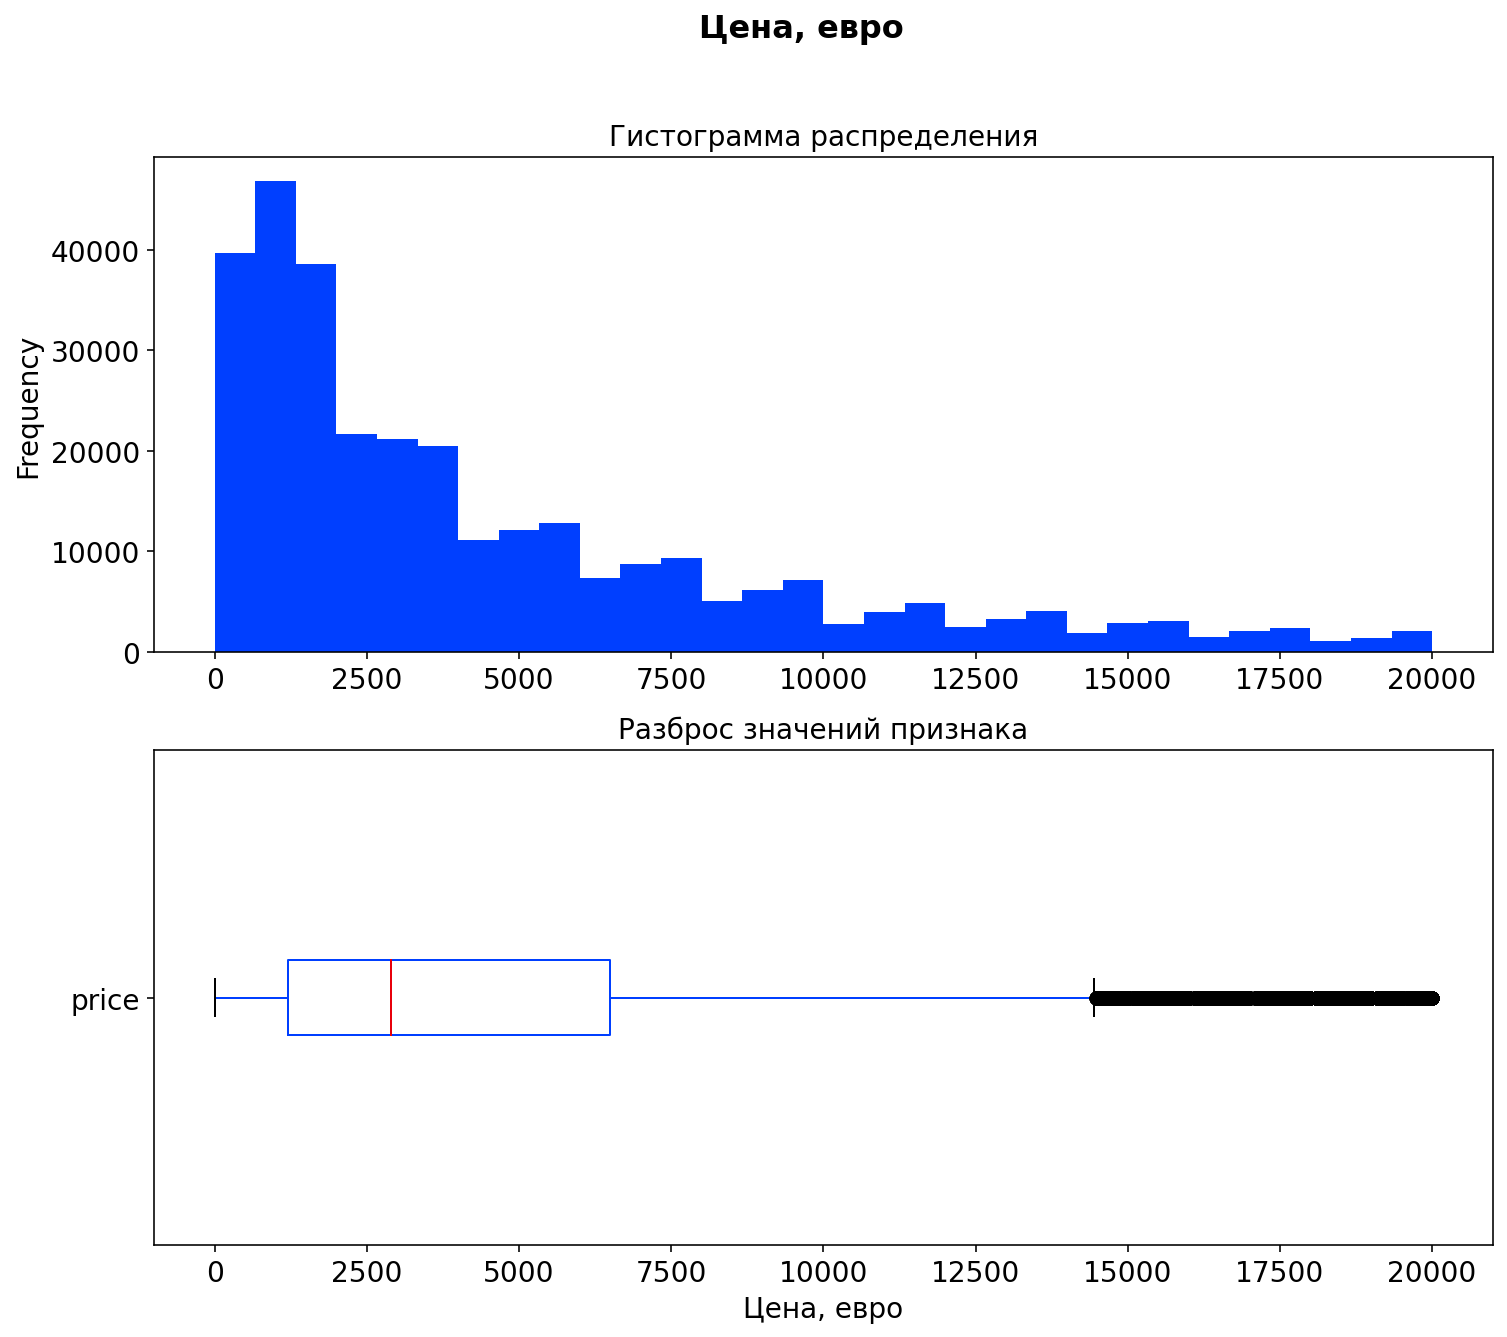

In [ ]:
build_hist_num_feature(filtered['price'], 30, 'Цена, евро')

In [ ]:
# расчет значений верхнего "уса" на диаграмме размаха
q3, q1 = np.percentile (filtered['price'], [75 ,25])
iqr = q3 - q1
upper = q3 + 1.5 * iqr

print(f'Верхняя граница {upper}')

Верхняя граница 14450.0


Гистограмма распределения цены автомобиля имеет форму распределения Пуассона. Медианное значение равно 2900 евро, а среднее смещено в сторону правого хвоста значений и равно 4607 евро.
На диаграмме размаха видны точки, выходящие за пределы верхнего "уса" равного 14700 евро. Они соответствуют наиболее дорогим моделям и не являются выбросами.

Статистика для Год регистрации

 count    307564.000000
mean       2002.542684
std           6.983742
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64


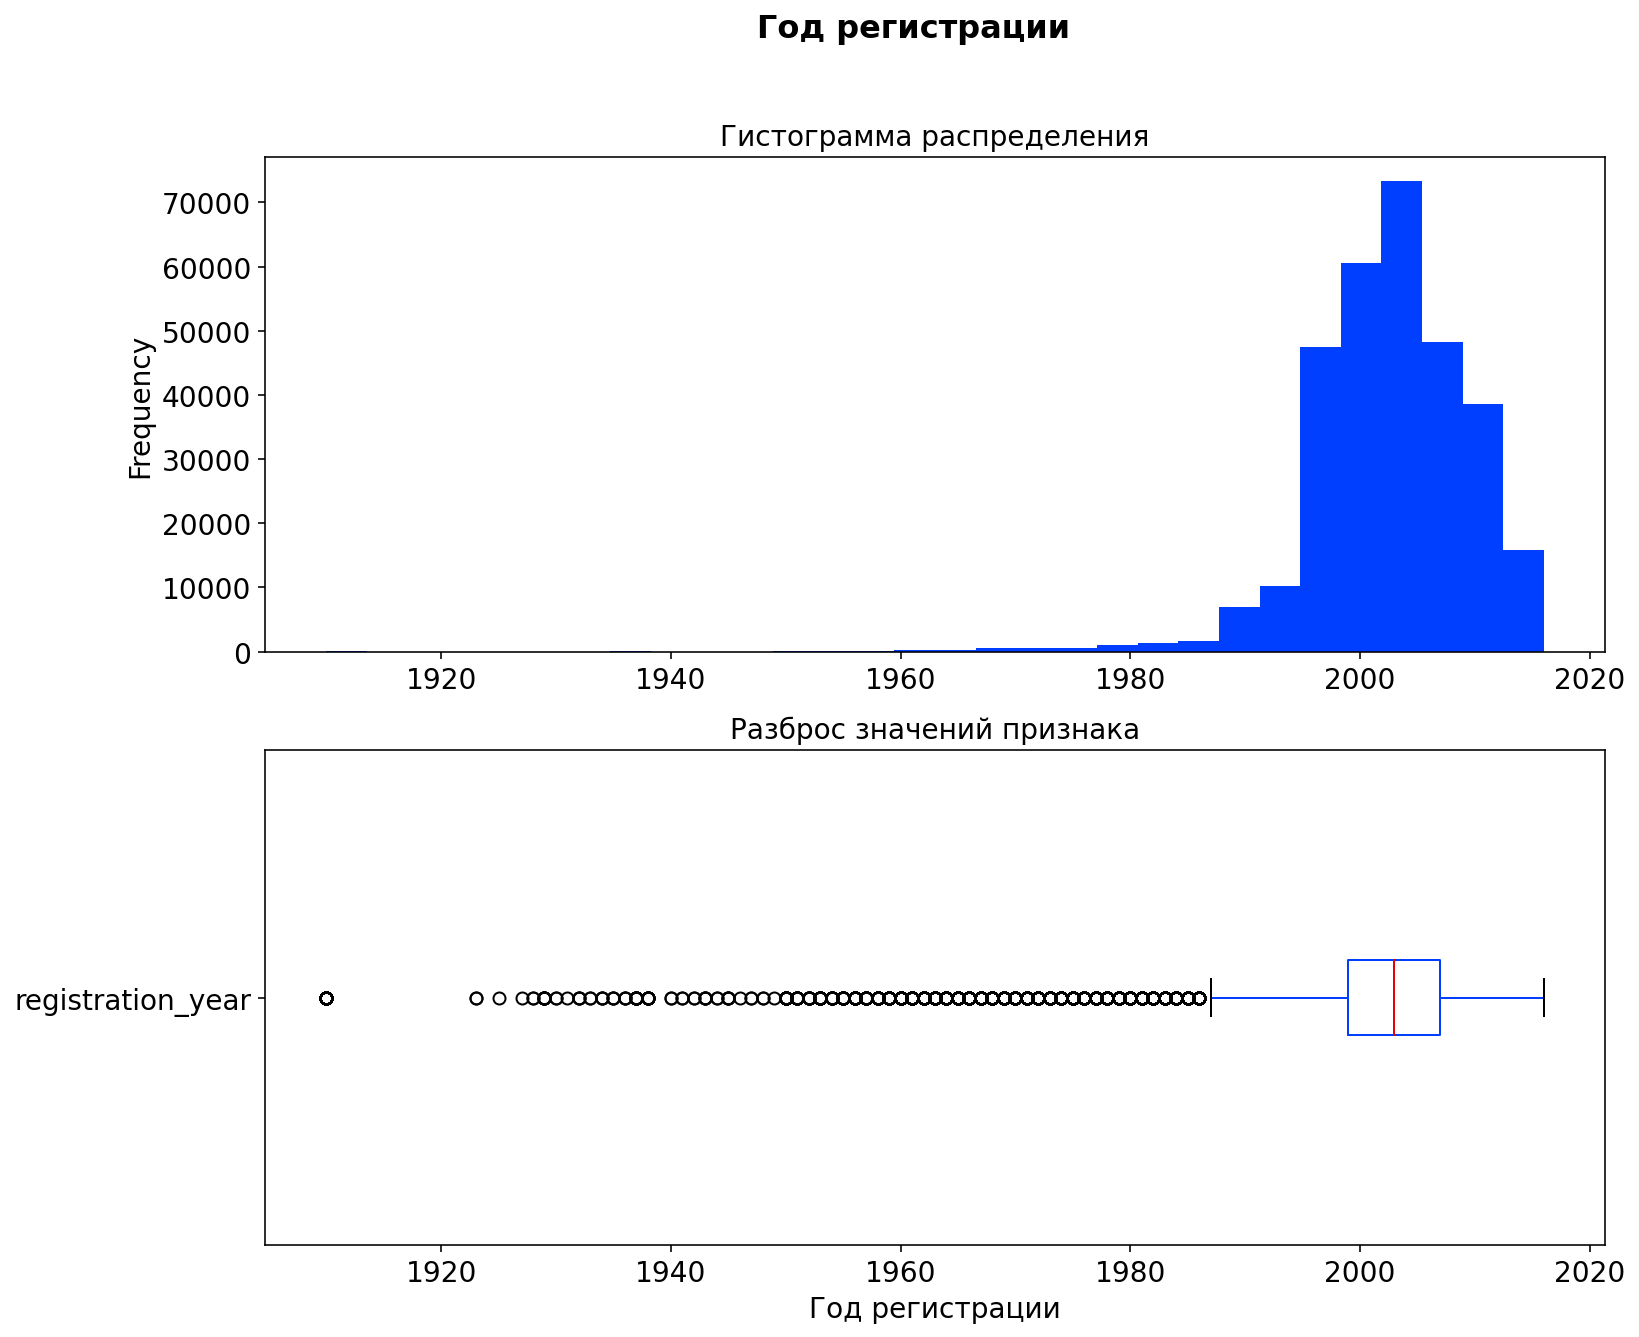

In [ ]:
build_hist_num_feature(filtered['registration_year'], 30, 'Год регистрации')

Гистограмма распределения смещена вправо и имеет длинный левый "хвост". 50% всех значений находится в диапазоне от 1999 до 2007 г. В выборке также присутствуют ретро автомобили с годом регистрации в первой половине прошлого века. На диаграмме размаха они характеризуются редеющей влево серией точек.

Статистика для  Мощность, л. с.

 count    307564.000000
mean        120.194969
std          67.835695
min           1.000000
25%          75.000000
50%         112.000000
75%         144.000000
max        4700.000000
Name: power, dtype: float64


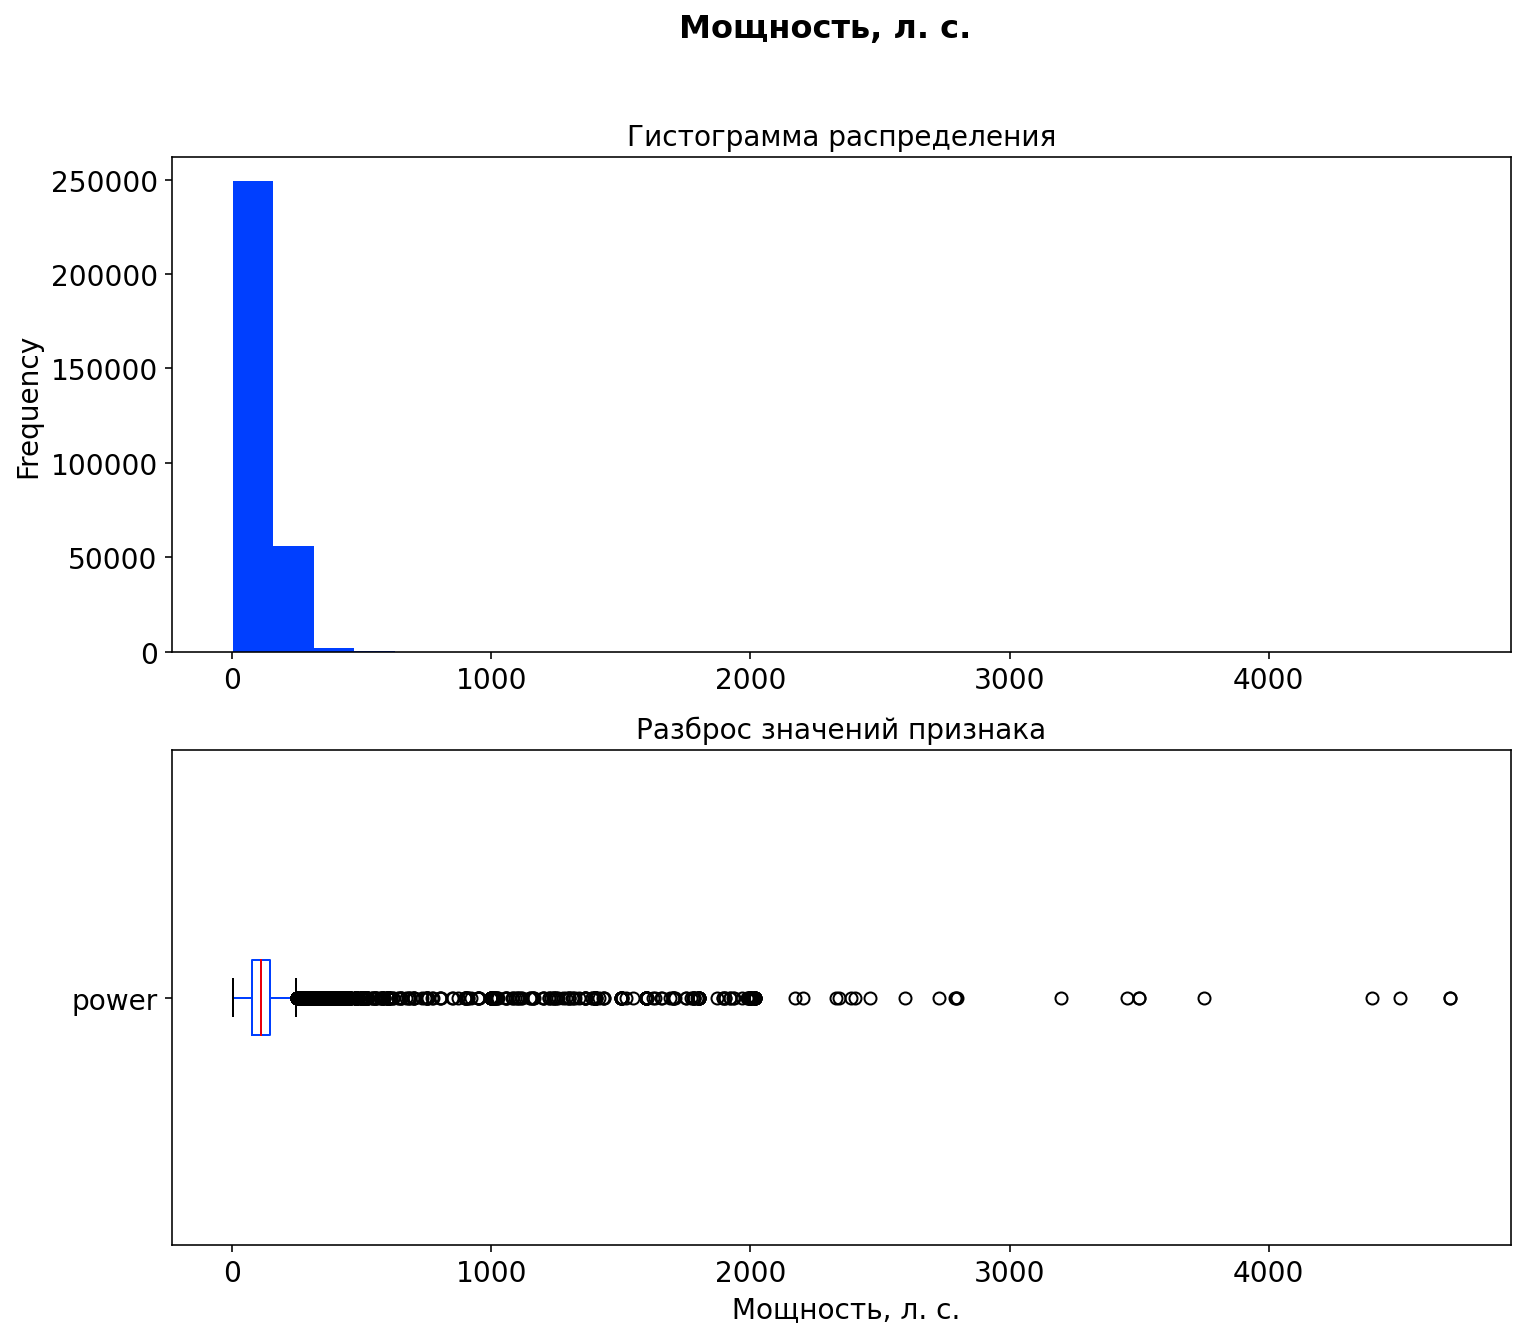

In [ ]:
build_hist_num_feature(filtered['power'], 30, ' Мощность, л. с.')

50% всех автомобилей в выборке имеют мощность двигателя от 75 до 145 л.с. Кроме того, по диаграмме размаха видно, что в выборке присутствуют более мощные машины. Максимальная мощность автомобиля в выборке равна 4700 л.с., а минимальная 1 л.с.

Статистика для Почтовый индекс владельца анкеты (пользователя)

 count    307564.000000
mean      50973.379784
std       25792.087502
min        1067.000000
25%       30627.000000
50%       49716.000000
75%       71686.000000
max       99998.000000
Name: postal_code, dtype: float64


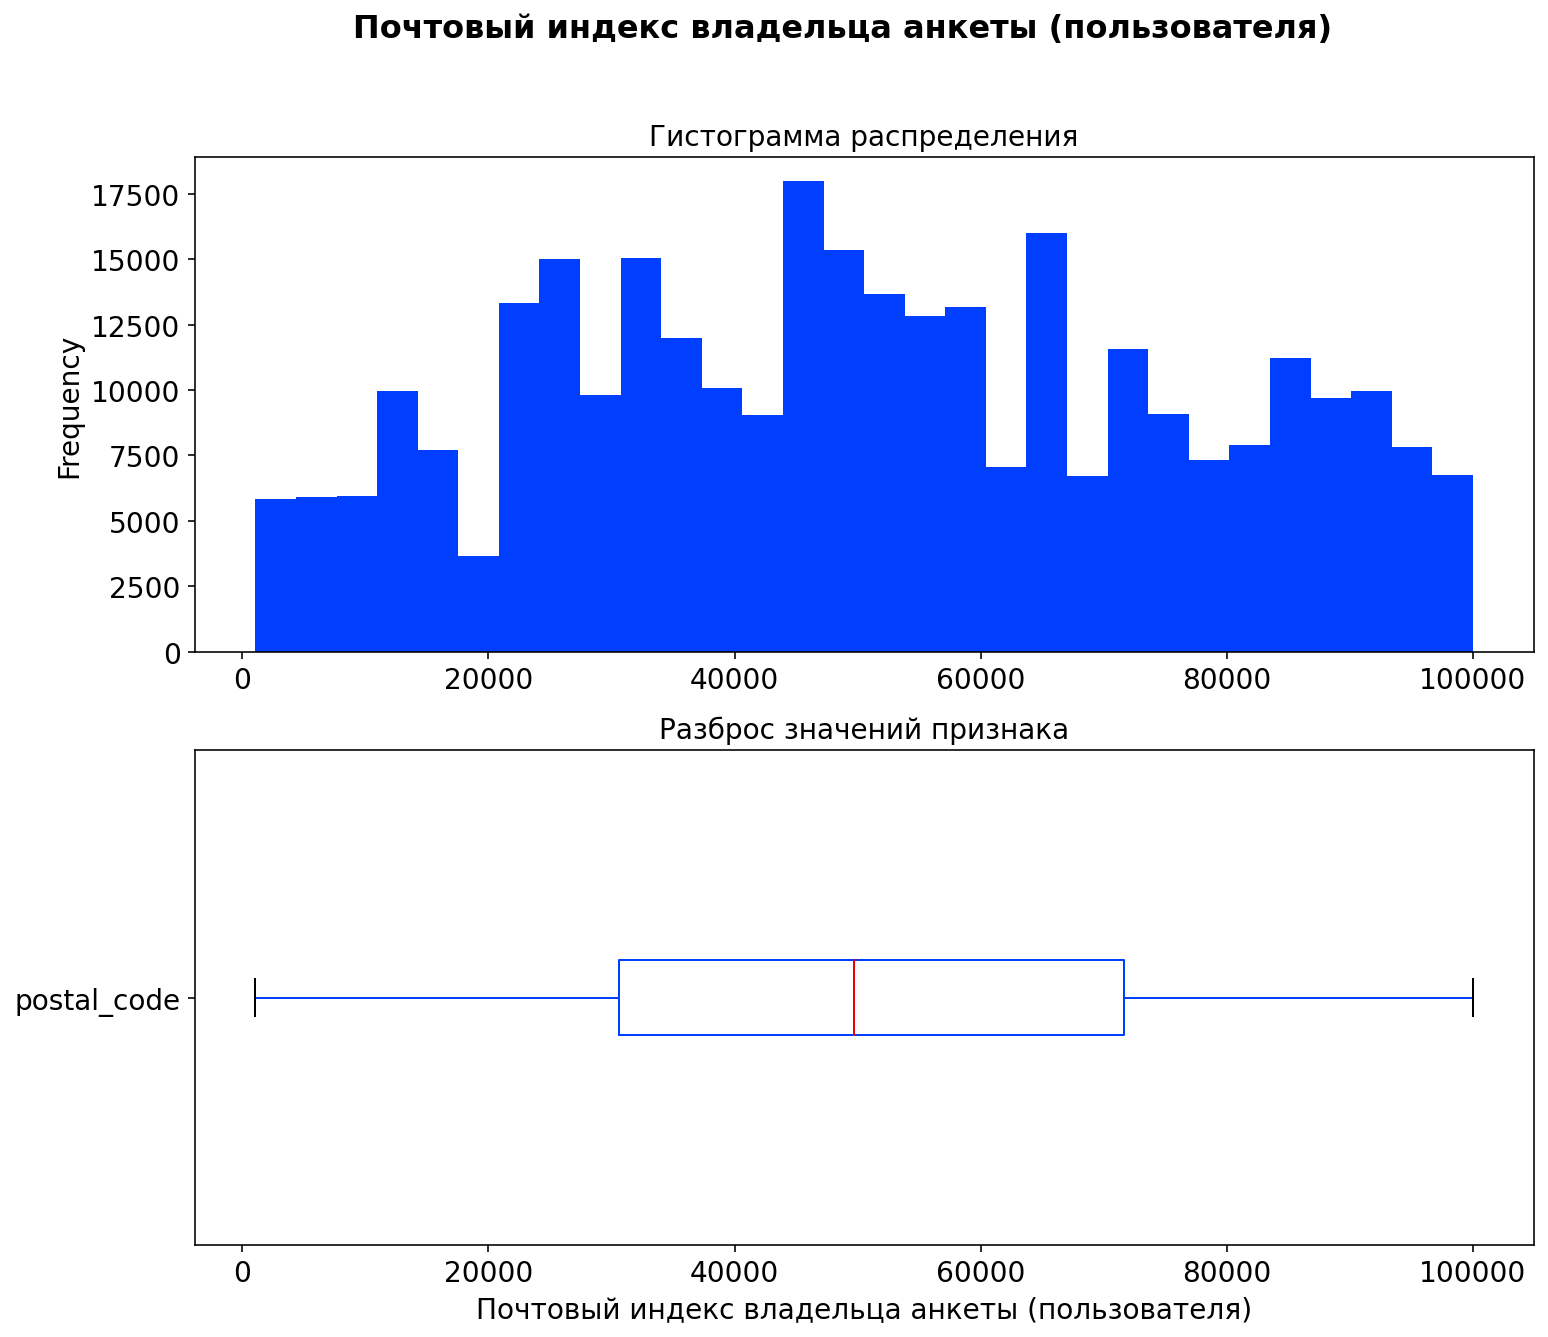

In [ ]:
build_hist_num_feature(filtered['postal_code'], 30, 'Почтовый индекс владельца анкеты (пользователя)')

Данные по почтовому индексу возможно не несут полузной информации при прогнозе стоимости автомобиля. На данном этапе оставим их и посмотрим на коэффициенты корреляции. Возможно присутствует зависимость между ценой продажи и регионом.

In [ ]:
# функция для построения горизонтальной столбчатой диаграммы для дискретного признака
# получение уникальных значений в столбце методом value_counts()
# преобразование полученного объекта Series в датафрейм методом to_frame()
# построение гистограммы методом plot() с типом kind='barh'

def disc_plot(feature, title, ylabel):
    # входные данные:
    # feature - название столбца с количественным признаком,
    # title - название признака для заголовка
    # xlabel - подпись оси


    filtered[feature] \
            .value_counts(ascending=True) \
            .to_frame() \
            .plot(y=feature, kind='barh',
                  legend=False, figsize=(8,8))

    plt.title(title, fontsize=16, fontweight="bold")
    plt.ylabel(ylabel, fontsize=14)

    # добавим метки для каждого столбца
    for index, value in enumerate(filtered[feature].value_counts(ascending=True)):
        plt.text(value, index, str(value), ha='left', va='center', fontsize=12)

    plt.show()

Только признак 'kilometer' можно рассматривать как дискретный. Построим для него горизонтальную столбчатую гистограмму и узнаем распределение автомобилей по пробегу.

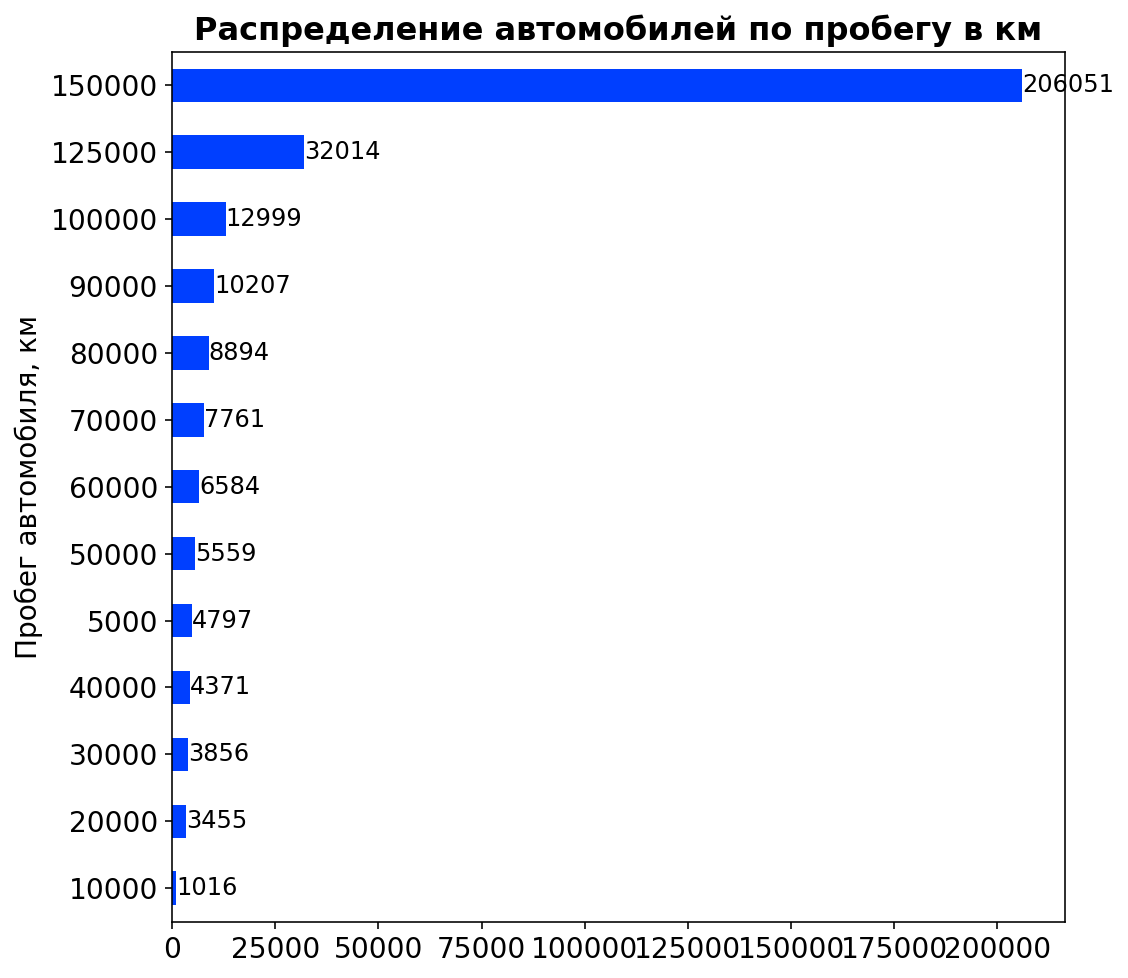

In [ ]:
disc_plot('kilometer', 'Распределение автомобилей по пробегу в км', 'Пробег автомобиля, км')

Подавляющее большинство всех автомобилей в датасете имеют пробег 150 тыс.км.

А теперь рассмотрим категориальные признаки. Построим для них диаграммы размаха цены в зависимости от каждого категориального признака, а также построим круговые диаграммы, чтобы узнать долю каждого класса в общем объеме данных.

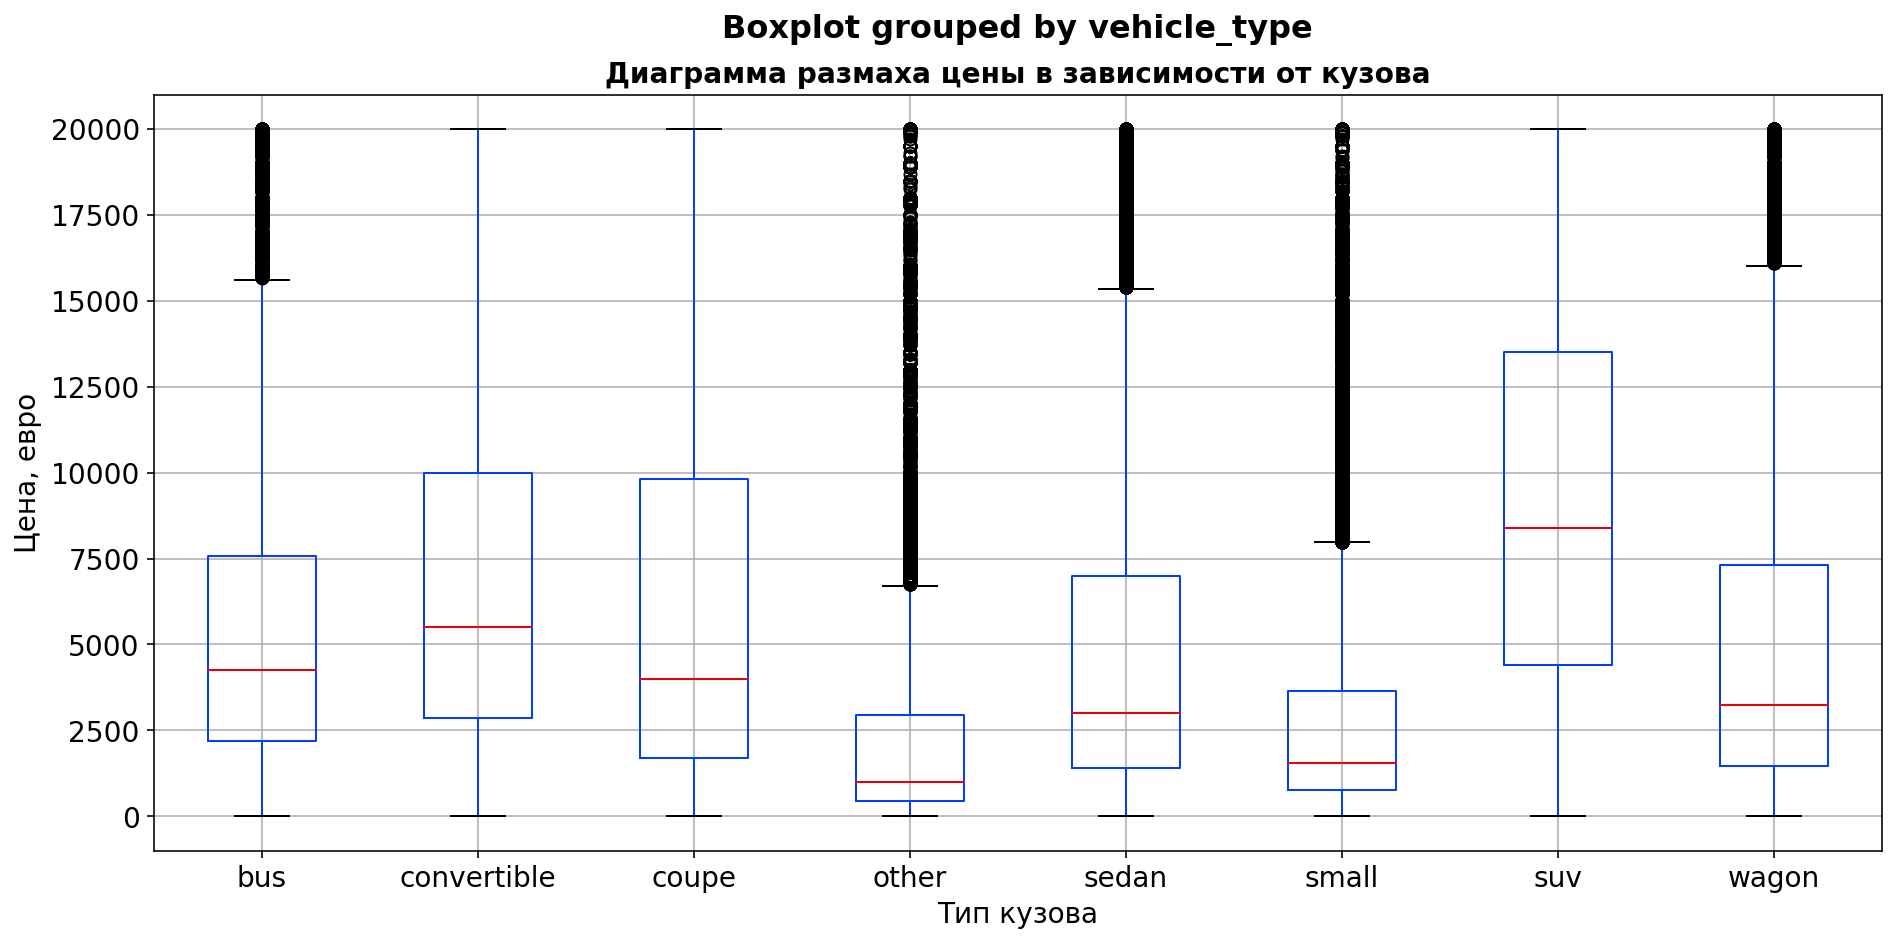

In [ ]:
# построение диаграммы размаха с указанием названия заголовка, подписи осей
filtered.boxplot(column='price', by='vehicle_type', figsize=(15, 7))
plt.title('Диаграмма размаха цены в зависимости от кузова')
plt.xlabel('Тип кузова', fontsize=14)
plt.ylabel('Цена, евро', fontsize=14)

plt.show()

In [ ]:
# функция build_pie_cat_feature для создания круговой диаграмы
def build_pie_cat_feature(title, feature):

    filtered[feature] \
        .value_counts() \
        .to_frame() \
        .plot(y=feature, kind='pie', autopct='%1.1f%%', legend=False, ylabel='',
              cmap='twilight', wedgeprops=dict(width=0.5), figsize=(13, 7))
    plt.title(title)

In [ ]:
# функция для построения диаграммы размаха цены в зависимости от категориального признака
def build_boxplot(title, feature):

    filtered.boxplot(column='price', by=feature, figsize=(15, 7))
    plt.title('Диаграмма размаха цены в зависимости от признака '+title)
    plt.xlabel(title)
    plt.ylabel('Цена, евро', fontsize=14)
    plt.show()

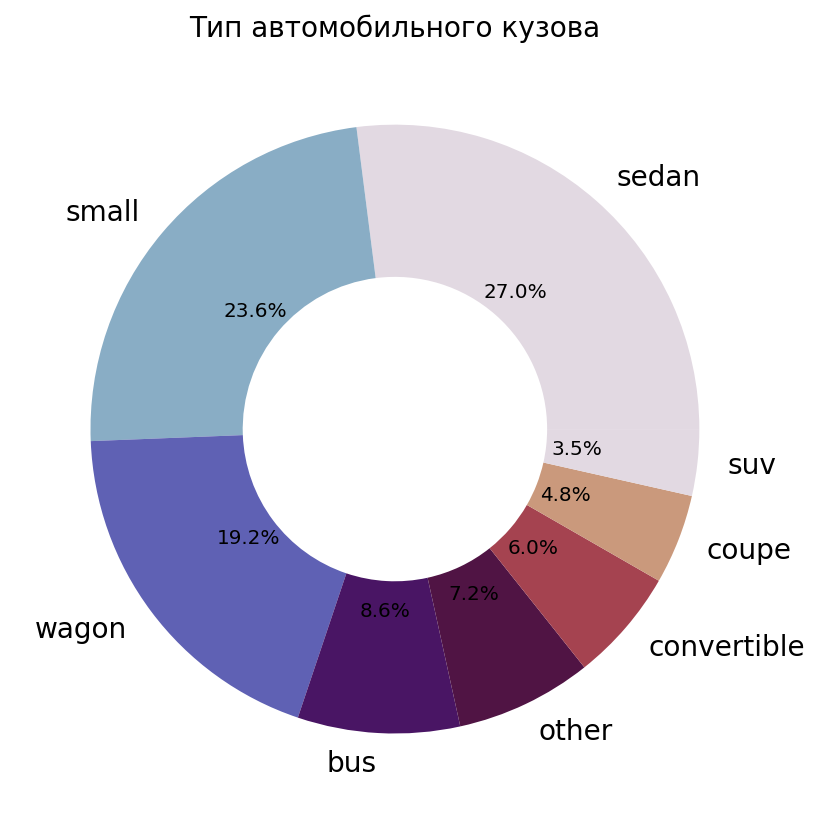

In [ ]:
build_pie_cat_feature('Tип автомобильного кузова', 'vehicle_type')

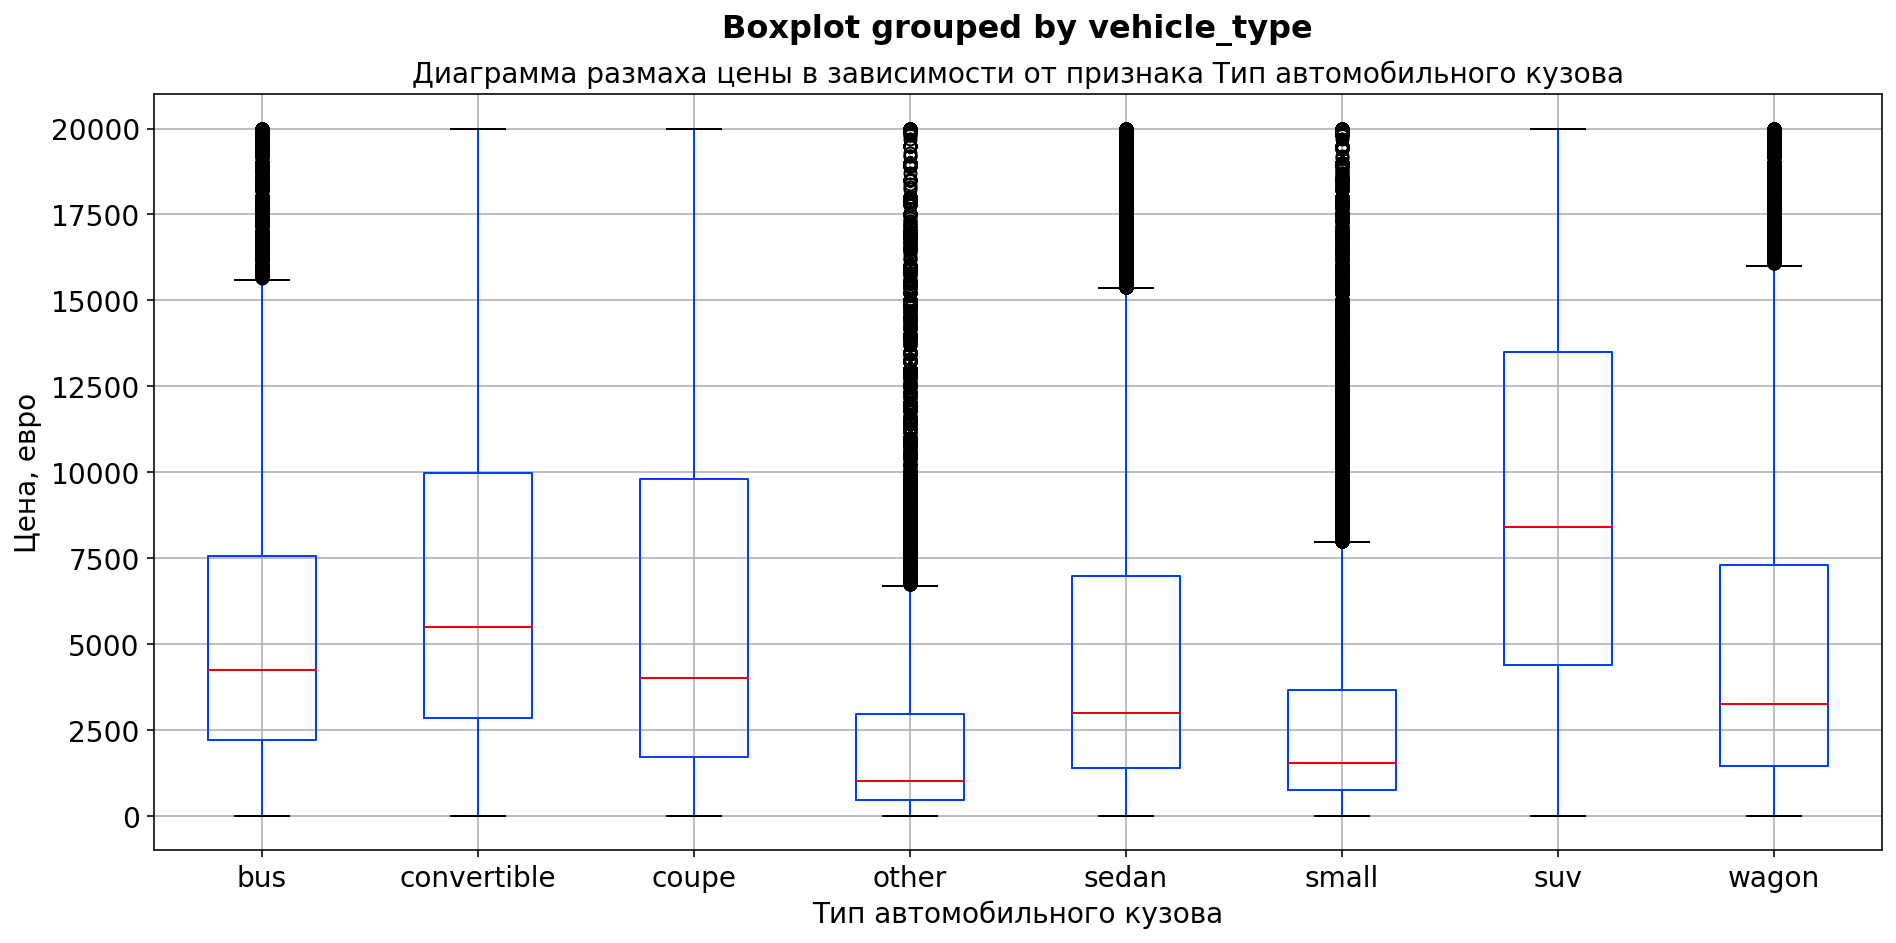

In [ ]:
build_boxplot('Tип автомобильного кузова', 'vehicle_type')

В выборке большинство автомобилей (27.1%) имеют кузов sedan. Также в топ-3 присутствуют small - 23.7% и wagon - 19.3%.

По стоимости наибольшей медианной ценой характеризуются машины с типом кузова suv, наименьшей - машины с неуказанным типом кузова.

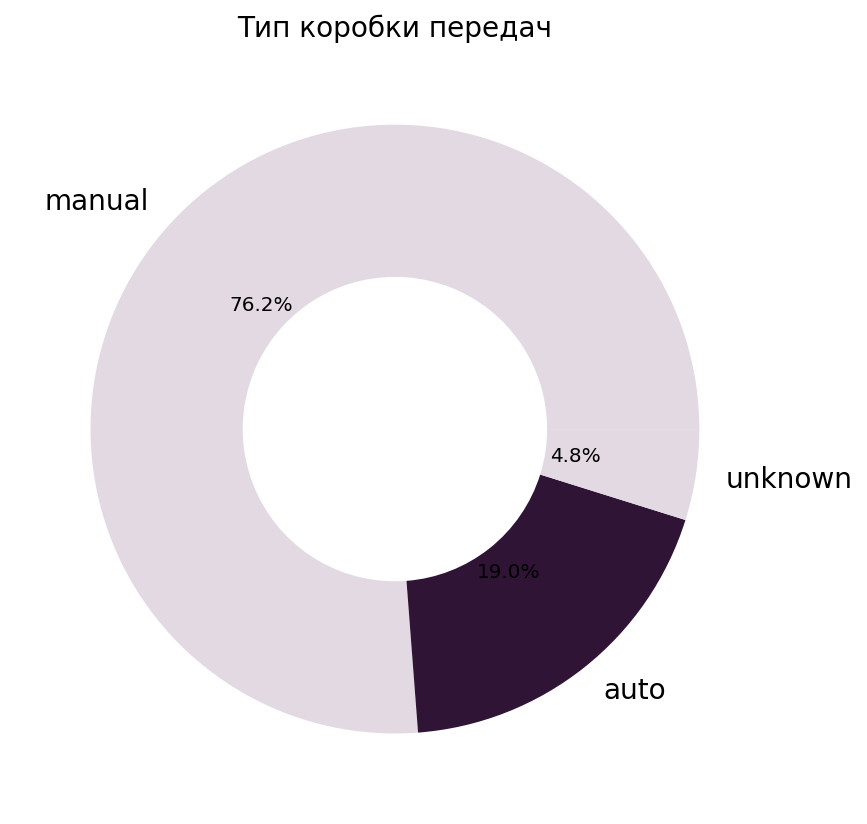

In [ ]:
build_pie_cat_feature('Тип коробки передач', 'gearbox')

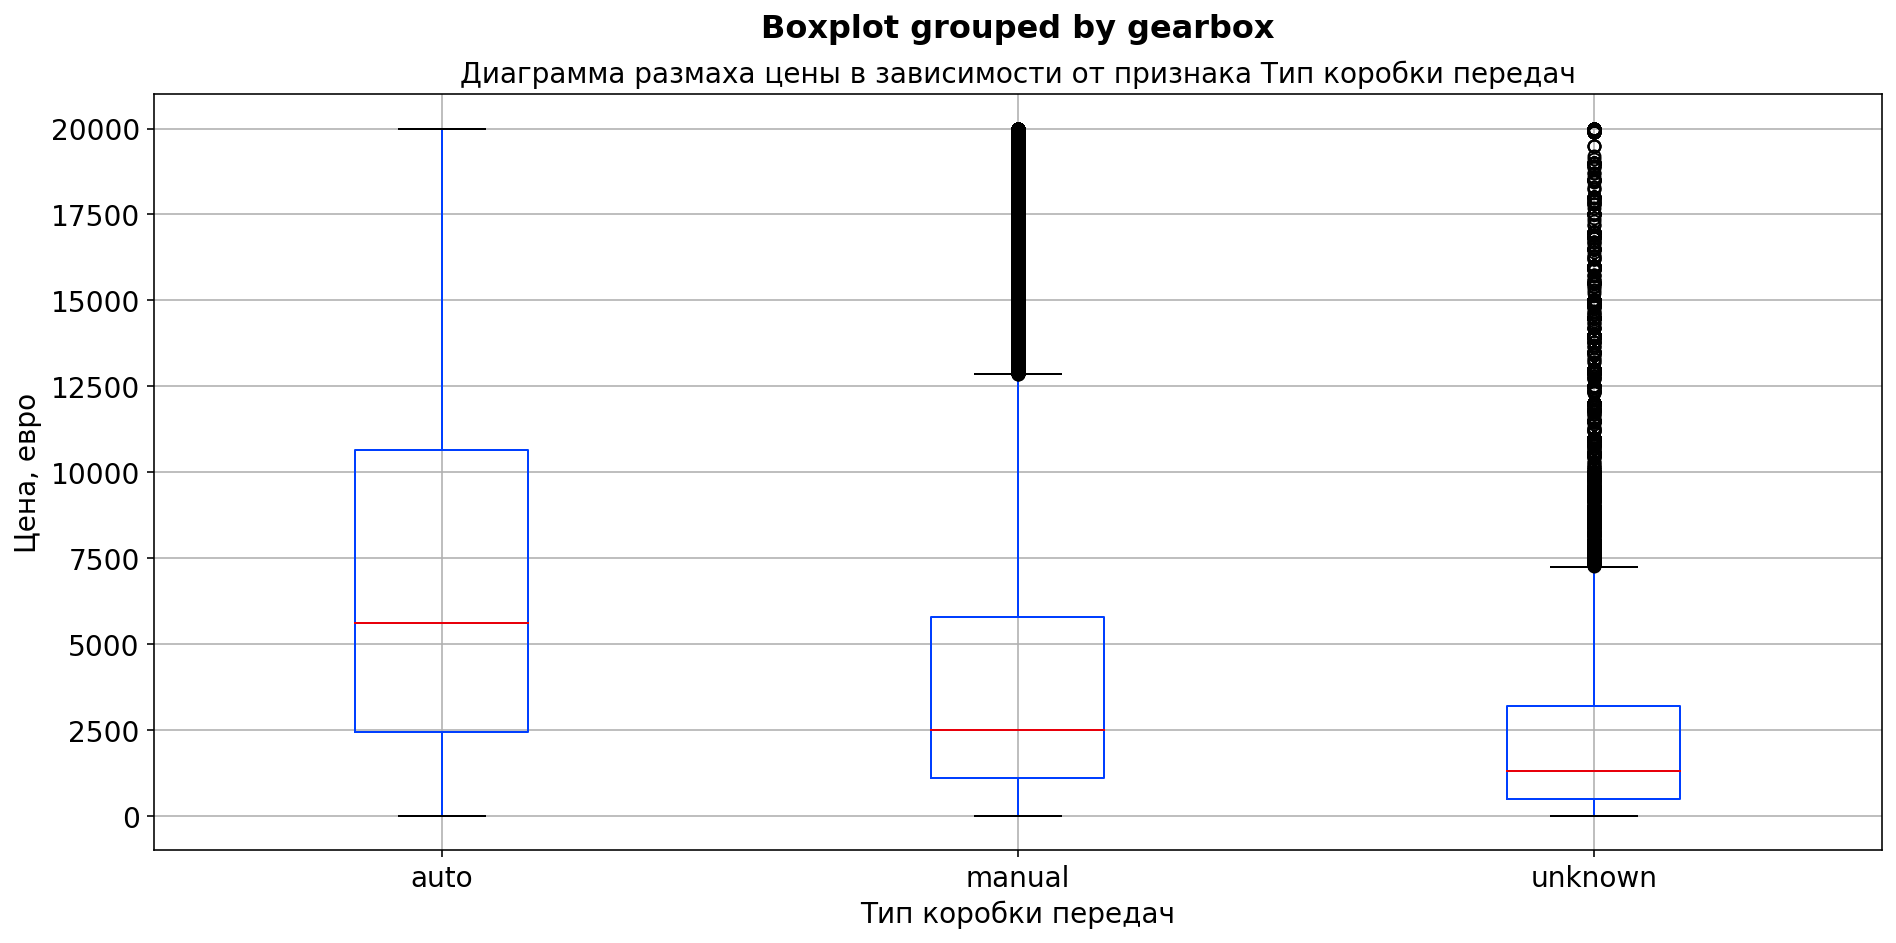

In [ ]:
build_boxplot('Тип коробки передач', 'gearbox')

Большинство автомобилей (76.2%) в исследуемых данных имеет ручную коробку передач. 19.1% имеет автоматическую коробку и для 4.7% тип коробки передач неизвестен.
По диаграмме размаха наблюдается влияние типа коробки передач на цену. Наиболее дорогими являются машины с автоматической коробкой передач.

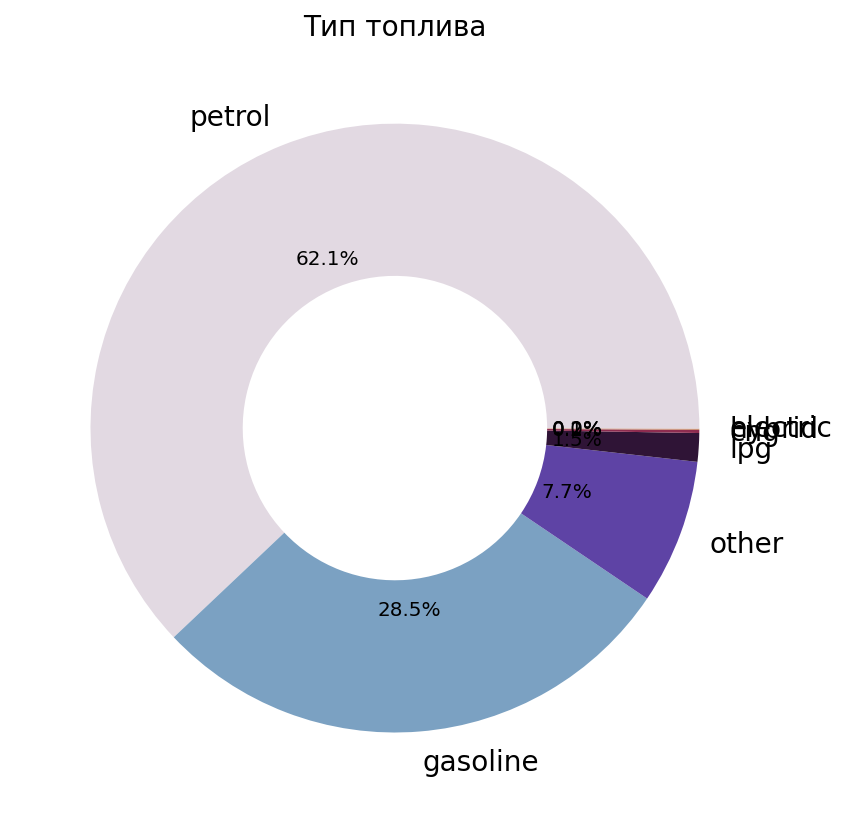

In [ ]:
build_pie_cat_feature('Тип топлива', 'fuel_type')

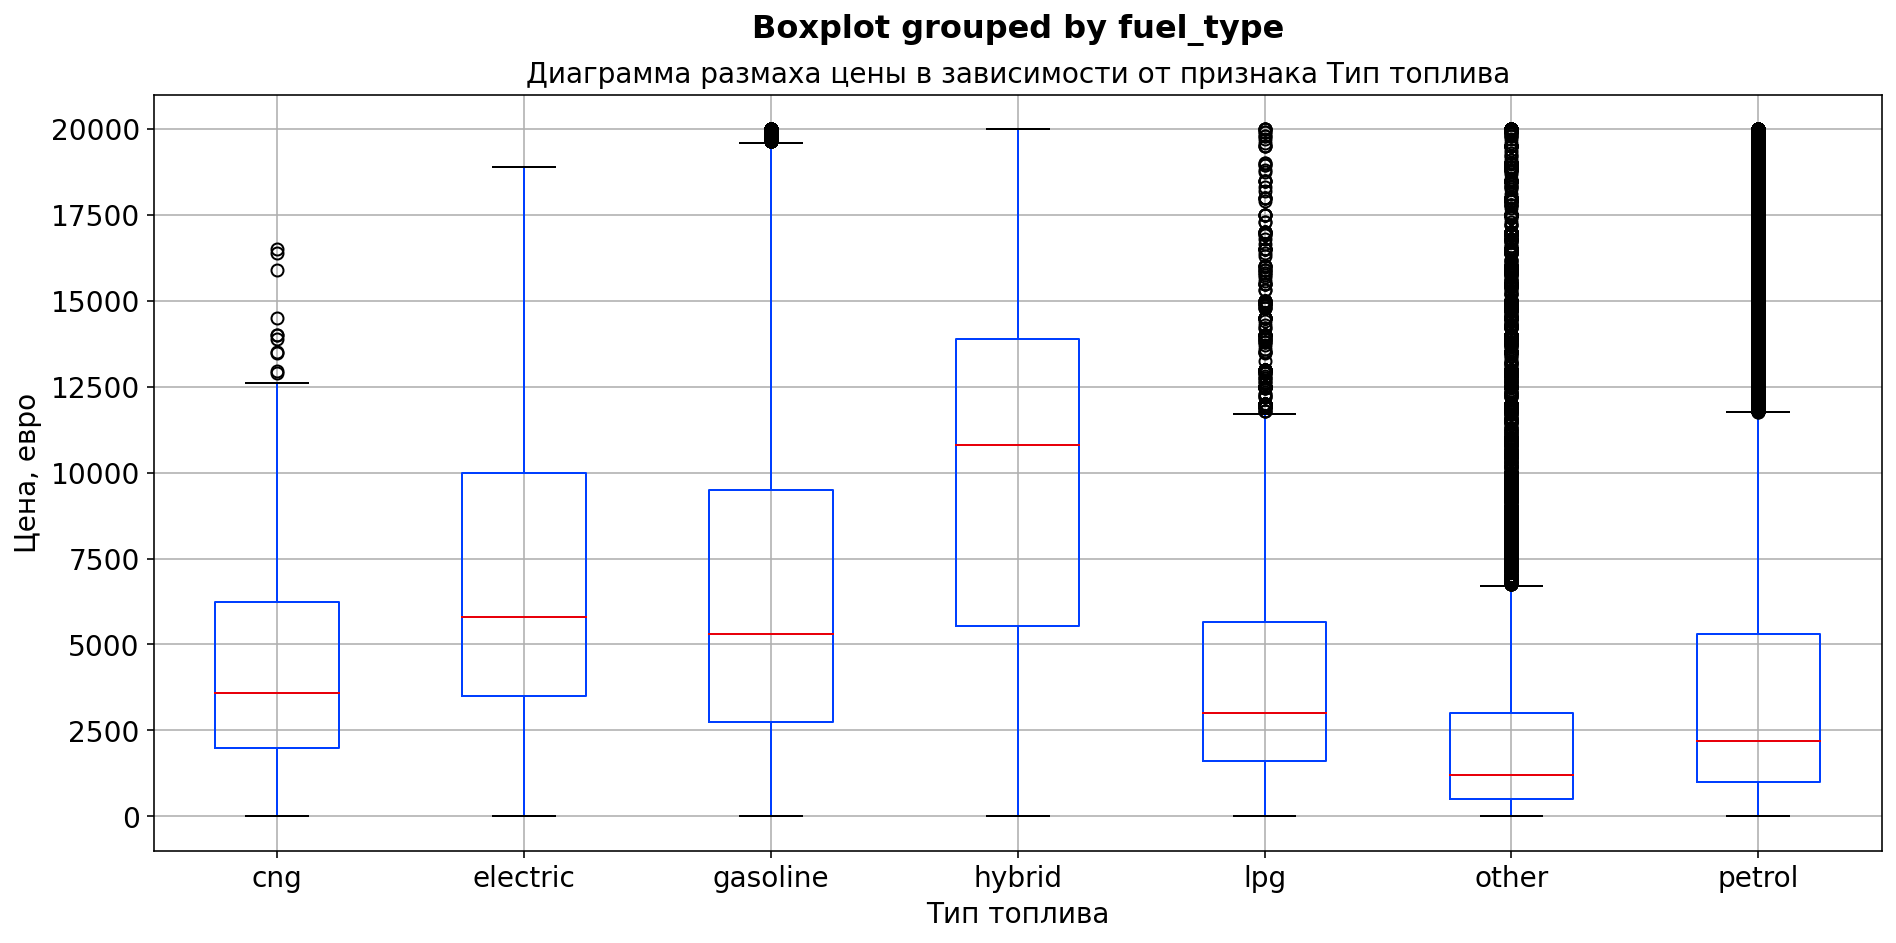

In [ ]:
build_boxplot('Тип топлива', 'fuel_type')

Большинство автомобилей в выборке имеют тип топлива petrol. Их доля составляет 62.1%. 28.8% имеют газовый двигатель. Для 7.4% тип топлива неизвестен. Наиболее дорогими являются автомобили с гибридным типом топлива.

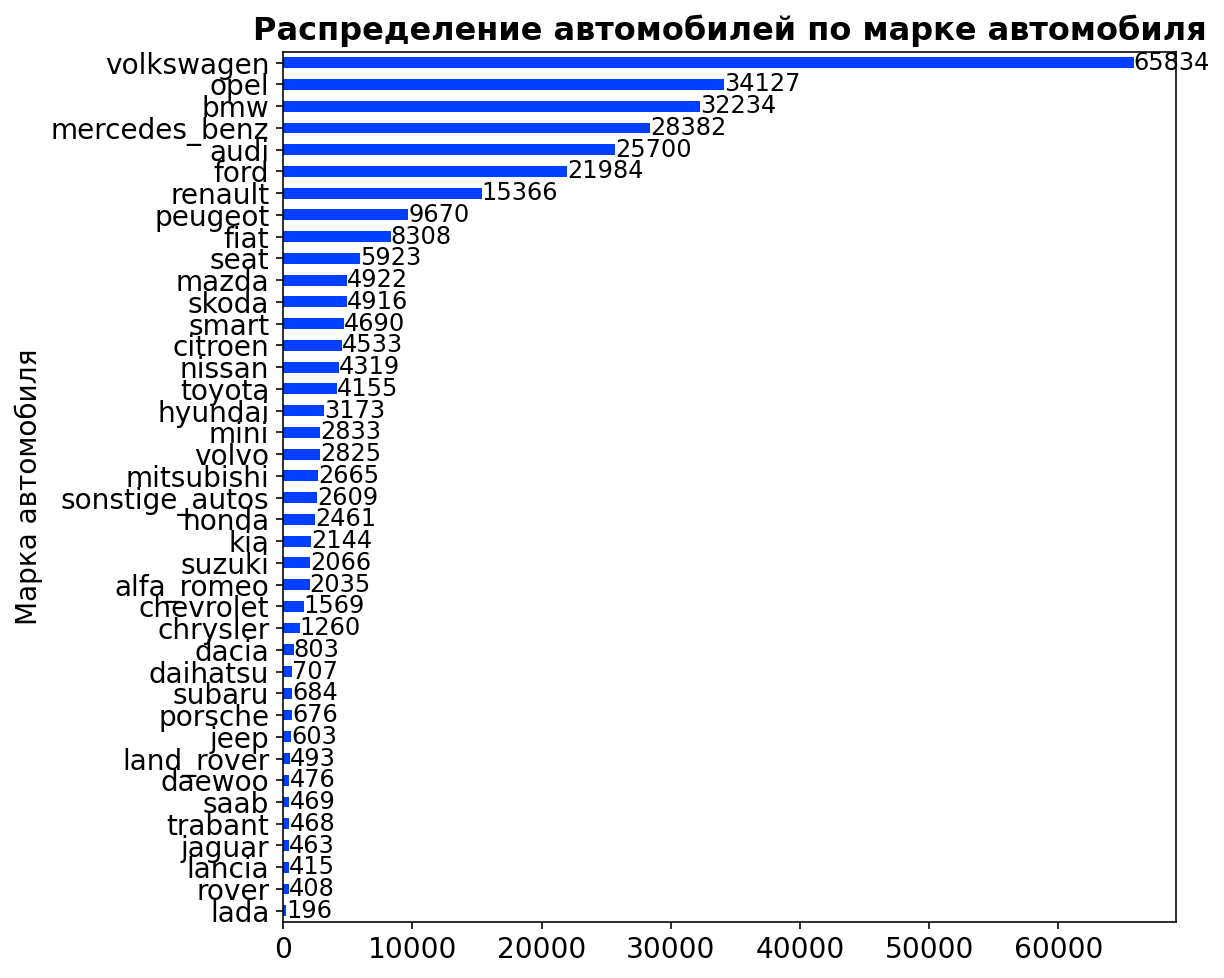

In [ ]:
disc_plot1('brand', 'Распределение автомобилей по марке автомобиля', 'Марка автомобиля')

Почти четверть, а именно 21.5% всех автомобилей в исходных данных марки Volkswagen. Также в топ-5 по количеству в выборке: Opel, BMW, Mercedes Benz и Audi.

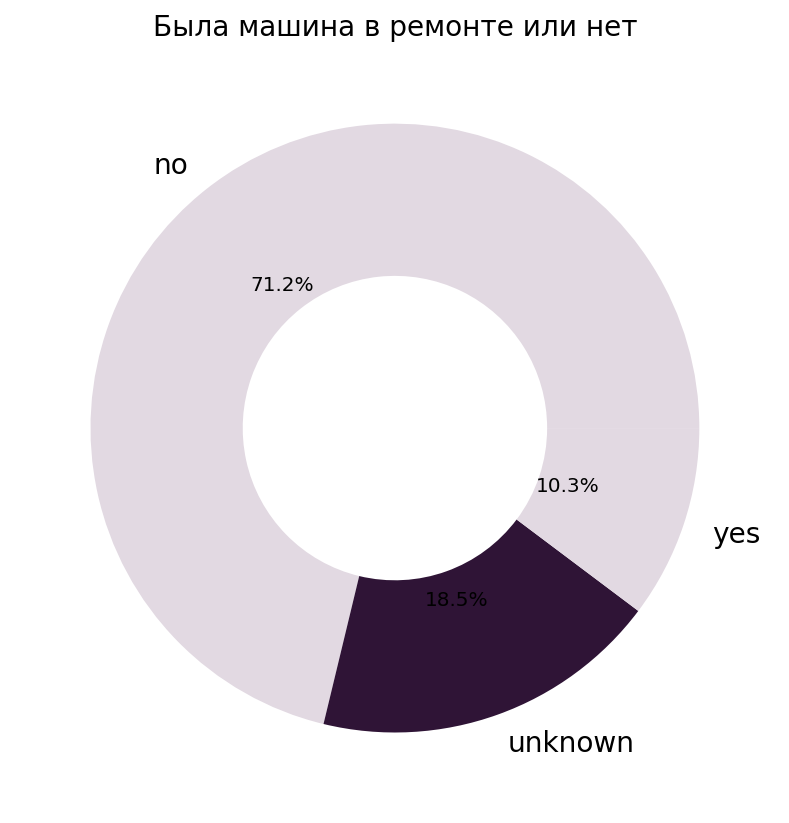

In [ ]:
build_pie_cat_feature('Была машина в ремонте или нет', 'repaired')

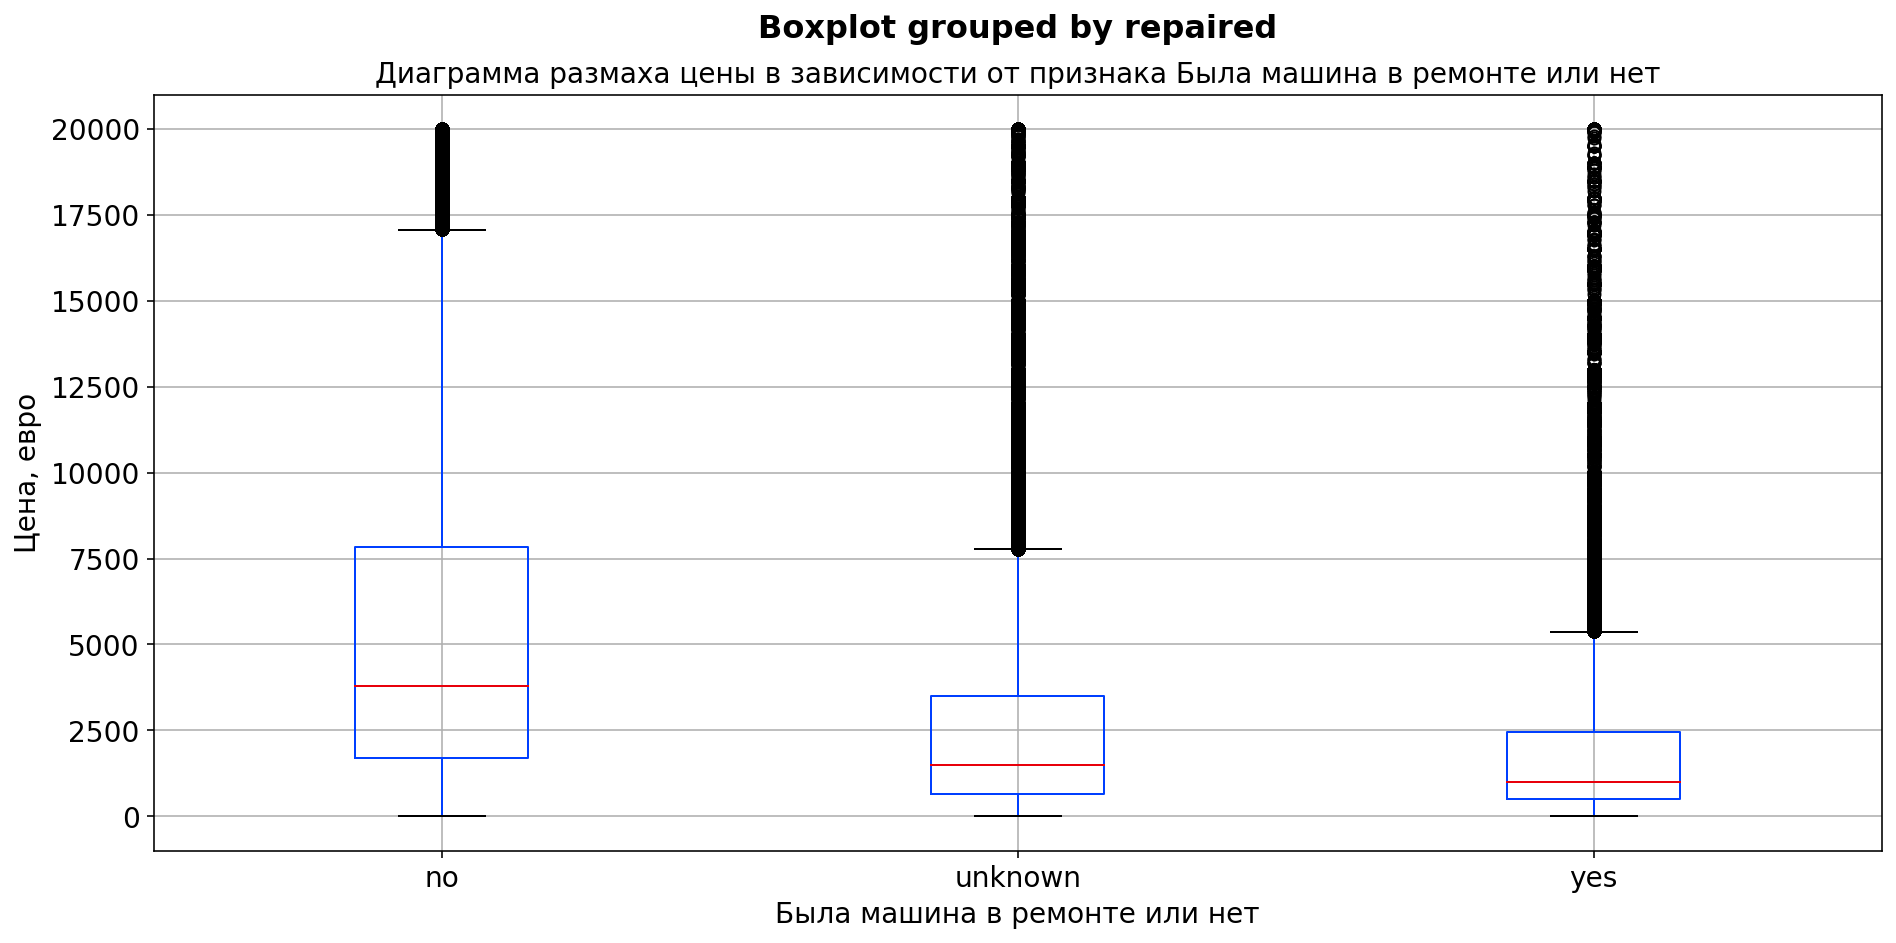

In [ ]:
build_boxplot('Была машина в ремонте или нет', 'repaired')

71.8% всех машин в выборке не были в ремонте, для 18.2% это неизвестно и 10% машин уже ремонтировались. Ожидаемо, машины, которые уже побывали в ремонте стоят дешевле неремонтированных.

Цена продажи является целевым признаком, поэтому оценим ее взаимосвязь с другими признаками по диаграмме рассеяния. Создадим функцию, которая в цикле будет строить диаграммы рассеяния между количественными признаками и ценой автомобиля.

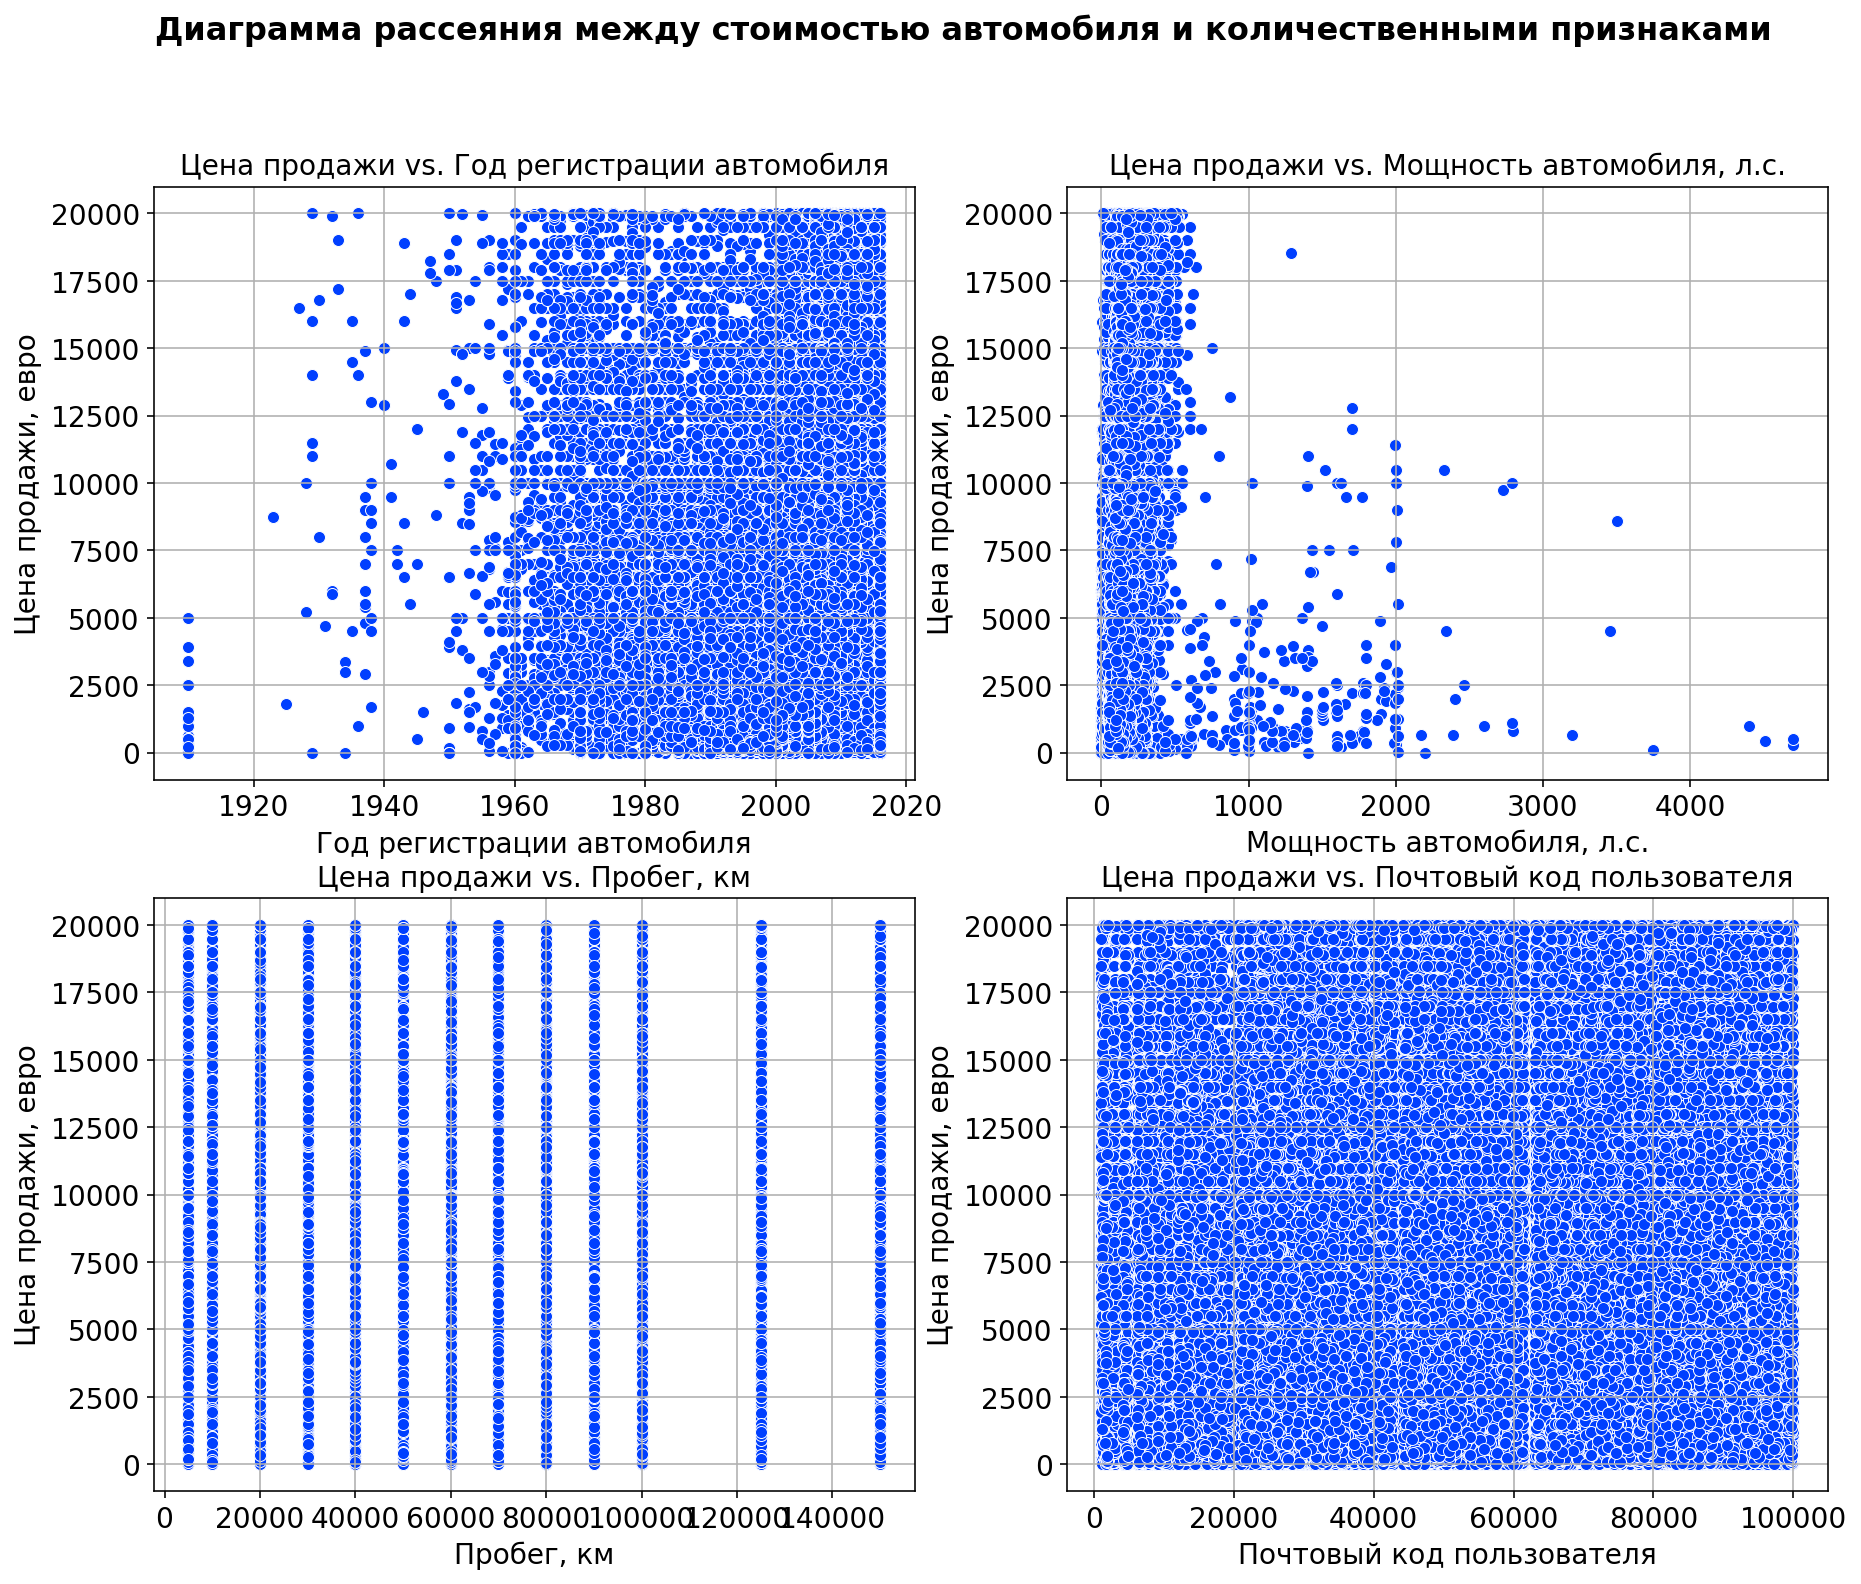

In [ ]:
fig = plt.subplots(figsize=(15, 12))
plt.suptitle('Диаграмма рассеяния между стоимостью автомобиля и количественными признаками')
a = 2
b = 2
c = 1

features = [('registration_year', 'Год регистрации автомобиля'), ('power', 'Мощность автомобиля, л.с.'),
               ('kilometer', 'Пробег, км'), ('postal_code', 'Почтовый код пользователя')]

for i, feature in enumerate(features):
    plt.subplot(a, b, c)
    plt.grid(True)
    plt.title('Цена продажи vs. '+feature[1])
    plt.xlabel(feature[1])
    plt.ylabel('Цена продажи, евро')
    sns.scatterplot(x=feature[0], y='price', data=filtered)
    c = c + 1
plt.show()

На графике зависимости цены от года регистрации заметно, что автомобили с годом регистрации до 1920 года стоят менее 5000 евро.
На графике зависимости цены от мощности прослеживается неожиданная закономерность: с ростом мощности стоимость автомобиля снижается.
Зависимость между ценой и пробегом и почтовым кодом не прослеживается. Графики зависимости с качественными признаками неинформативны, поэтому здесь не приводятся.

Рассчитаем коэффициенты корреляции между признаками разных типов данных. Для этого используем библиотеку phik.

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable postal_code is large: 8133. Are you sure this is not an interval variable? Analysis for pairs of variables including postal_code can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 2025117. Are interval variables set correctly?
  warnings.warn(


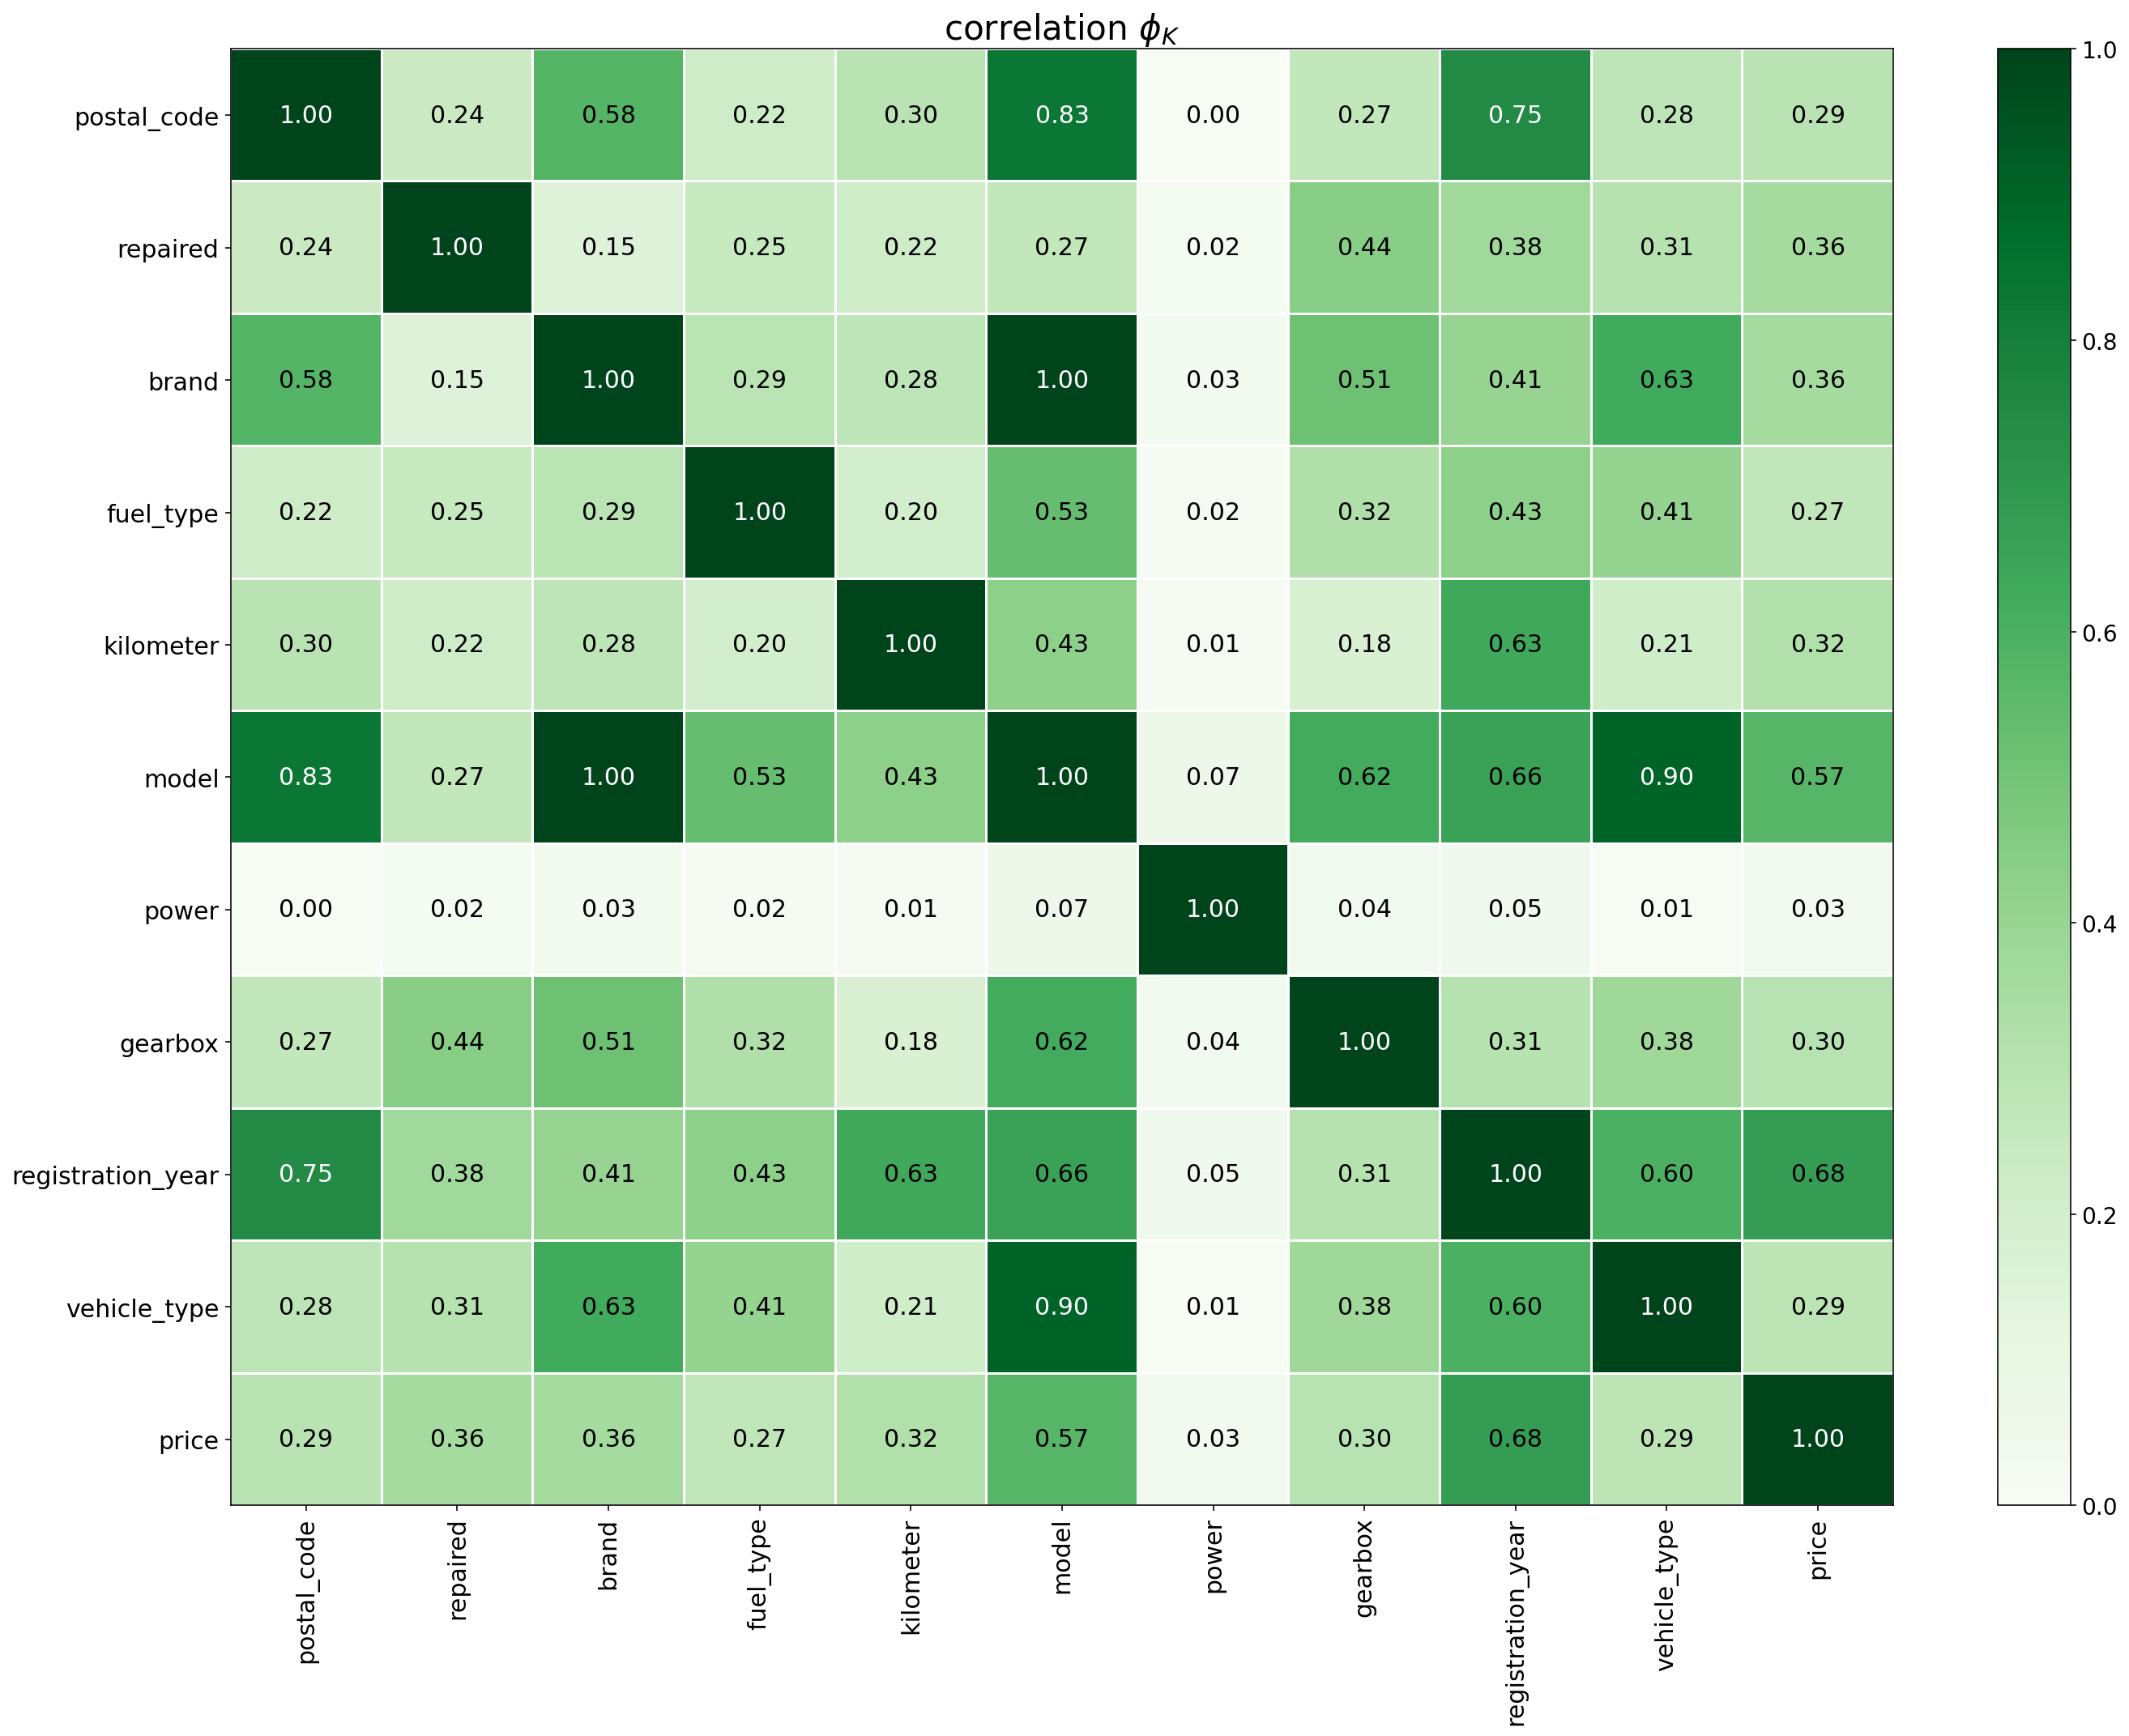

In [ ]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['price', 'power']

# считаем коэффициенты корреляции
phik_overview = phik_matrix(filtered, interval_cols=interval_cols)

# строим матрицу корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)
plt.show()

Между признаками 'model' и 'brand' наблюдается мультиколлинеарность: коэффициент корреляции между ними равен 1. Поэтому один из них нужно удалить. Признак 'model' имеет больший коэффициент корреляции с целевым признаком 'price', чем 'brand', поэтому оставим его.

## Часть 4. Обучение моделей

Все аномалии и пропуски были обработаны ранее, поэтому в пайплайн добавим только предобработку для новых данных, которые в последующем могут добавиться.

Количественные признаки имеют разный масштаб, поэтому их все нужно перемасштабировать. Используем для этого StandardScaler().

Категориальные признаки нужно закодировать с помощью One-Hot Encoder. Конечно, для некоторых признаков, особенно 'model' имеется больше количество уникальных значений, что может привести к более долгой обработке признаков.

In [ ]:
# задание константных значений
RANDOM_STATE = 42
TEST_SIZE = 0.25

# записываем входные данные в переменную Х, целевой признак в переменную у
X = filtered.drop(['price', 'brand'], axis=1)
y = filtered['price']

# делим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

print(f"Размер обучающей выборки: {X_train.shape}, тестовой выборки: {X_test.shape}")

# создаём списки с названиями признаков
ohe_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
num_columns = ['power', 'registration_year', 'kilometer', 'postal_code']

# создание переменной с экземпляром класса OneHotEncoder()
# включение параметр для избегания появления дамми-ошибок drop='first',
# отключение sparse-отображения
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# обучение и трансформация категориальных признаков из тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])

# преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[ohe_columns])

# получение от кодировщика списка новых столбцов и сохранение их в новой переменной
encoder_col_names = encoder.get_feature_names()

# создание тренировочного и тестового датафрейма из закодированных данных
# для данных OHE названия столбцов взяты из переменной encoder_col_names

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

# создание переменной с экземпляром класса StandartScaler()
scaler = StandardScaler()

# обучение и трансформация количественных признаков из тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[num_columns])

# преобразование количественных признаков в тестовой выборке
X_test_scaled = scaler.transform(X_test[num_columns])

# создание тренировочного и тестового датафрейма из отмасштабированных данных
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

# объединение всех преобразованных данных в тренировочный и тестовый датафреймы

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Размер обучающей выборки: (230673, 9), тестовой выборки: (76891, 9)


## Модель LightGBM

In [ ]:
# передадим словарь с параметрами для LightGBM моделирования
params = {'learning_rate': [0.05],
              'n_estimators': [100, 150],
              'num_leaves': [25, 35],
              'min_child_samples': [1],
              'colsample_bytree': [0.9]
}

# инициализируем модель LGBMRegressor
model = lgb.LGBMRegressor(objective='regression', random_state=RANDOM_STATE)

grid_search = GridSearchCV(model,
                          params,
                          verbose = 1,
                          cv = 5,
                          scoring='neg_root_mean_squared_error',
                          n_jobs = -1)

# запуск поискa  лучших гиперпараметров
grid_search.fit(X_train, y_train)

# сохраняем лучшую модель и её метрику
lgbm_model = grid_search.best_estimator_
rmse_lgbm = grid_search.best_score_ * (-1)

print('Лучшая модель и её параметры:\n\n', lgbm_model)
print (f'Метрика лучшей модели: {rmse_lgbm:.2f}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшая модель и её параметры:

 LGBMRegressor(colsample_bytree=0.9, learning_rate=0.05, min_child_samples=1,
              n_estimators=150, num_leaves=35, objective='regression',
              random_state=42)
Метрика лучшей модели: 1771.65


Лучшей моделью LGBMRegressor оказалась модель с параметрами colsample_bytree=0.9, learning_rate=0.05, min_child_samples=1, n_estimators=150, num_leaves=35, objective='regression', random_state=42.
Ее метрика RMSE = 1771.65 евро.

In [ ]:
# запуск счетчика времени обучения
start = time()

# обучим модель на тренировочных данных
lgbm_model.fit(X_train, y_train)

# остановка счетчика времени
end = time()

model_time_lgbm = (end-start)/60

print(f'Время расчета {model_time_lgbm} минут')

# запуск счетчика времени предсказания
start_p = time()

# получение предсказаний на тренировочных данных
lgbm_model.predict(X_train)

# остановка счетчика времени
end_p = time()

pred_time_lgbm = (end_p - start_p) / 60

print(f'Время предсказания {pred_time_lgbm} минут')

Время расчета 0.2966241598129272 минут
Время предсказания 0.07527557214101156 минут


Посмотрим также на метрики модели линейной регрессии и модели регрессии решающего дерева.

## Модель LinearRegression

In [ ]:
# инициализация модели линейной регрессии
model  = LinearRegression()

params = {
    'fit_intercept': [True, False],
    'positive' : [True, False]
}

gs = GridSearchCV(model,
                  params,
                  cv = 5,
                  scoring='neg_root_mean_squared_error',
                  n_jobs = -1)

gs.fit(X_train, y_train)

model_lr = gs.best_estimator_
rmse_lr = gs.best_score_ * (-1)

print('Лучшая модель и её параметры:\n\n', model_lr)
print (f'Метрика лучшей модели: {rmse_lr:.2f} евро')

Лучшая модель и её параметры:

 LinearRegression(fit_intercept=False, positive=True)
Метрика лучшей модели: 3131.16 евро


Лучшей моделью линейной регрессии оказалась модель с параметрами fit_intercept=False, positive=True. Ее метрика 3131.16 евро.

In [ ]:
# запуск счетчика времени
start = time()

# обучим модель на тренировочных данных
model_lr.fit(X_train, y_train)

# остановка счетчика времени
end = time()

model_time_lr = (end-start)/60

print(f'Время расчета {model_time_lr} минут')

# запуск счетчика времени предсказания
start_p = time()

# получение предсказаний на тренировочных данных
model_lr.predict(X_train)

# остановка счетчика времени
end_p = time()

pred_time_lr = (end_p - start_p) / 60

print(f'Время предсказания {pred_time_lr} минут')

Время расчета 0.5348504741986593 минут
Время предсказания 0.0018602689107259116 минут


## Модель DecisionTreeRegressor

Для модели DecisionTreeRegressor создадим словарь с гиперпараметрами и воспользуемся автоматическим подбором наилучших параметров с помощью GriddSearchCV.

In [ ]:
# задание гиперпараметров модели DecisionTreeRegressor
param = {
    'max_depth': [None, 15, 30],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 5]
}

# запуск автоматического подбора параметров с помощью GridSearchCV
grid_search = GridSearchCV(
                            DecisionTreeRegressor(random_state=RANDOM_STATE),
                            param,
                            scoring='neg_root_mean_squared_error',
                            cv=5)

grid_search.fit(X_train, y_train)
model_dtr = grid_search.best_estimator_
rmse_dtr = grid_search.best_score_*(-1)

print('Лучшая модель и её параметры:\n\n', model_dtr)
print (f"Метрика на лучшей модели тренировочных данных RMSE = {rmse_dtr:.2f}")

Лучшая модель и её параметры:

 DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, random_state=42)
Метрика на лучшей модели тренировочных данных RMSE = 1948.33


Лучшей моделью DecisionTreeRegressor оказалась модель с параметрами max_depth=15, min_samples_leaf=5, min_samples_split=15. Ее метрика RMSE = 1936.9 евро.

In [ ]:
# запуск счетчика времени
start = time()

# обучим модель на тренировочных данных
model_dtr.fit(X_train, y_train)

# остановка счетчика времени
end = time()

model_time_dtr = (end-start)/60

# запуск счетчика времени предсказания
start_p = time()

# получение предсказаний на тренировочных данных
model_dtr.predict(X_train)

# остановка счетчика времени
end_p = time()

pred_time_dtr = (end_p - start_p) / 60

print(f'Время предсказания {pred_time_dtr} минут')

Время предсказания 0.0035319169362386066 минут


## Часть 5. Aнализ моделей

Соберем метрики и время расчета и предсказания по всем моделям в датафрейм.

In [ ]:
result = pd.DataFrame(
    {
    "Модель": ['LightGBM', 'LinearRegression', 'DecisionTreeRegressor'],
    "RMSE": [rmse_lgbm, rmse_lr, rmse_dtr],
    "Время обучения, мин": [model_time_lgbm, model_time_lr, model_time_dtr],
    "Время предсказания, мин": [pred_time_lgbm, pred_time_lr, pred_time_dtr]
    }
)

result['Время работы, мин'] = result['Время обучения, мин'] + result['Время предсказания, мин']
result

,Модель,RMSE,"Время обучения, мин","Время предсказания, мин","Время работы, мин"
0,LightGBM,1771.648525,0.296624,0.075276,0.371900
1,LinearRegression,3131.159443,0.534850,0.001860,0.536711
2,DecisionTreeRegressor,1948.329245,0.083685,0.003532,0.087217


Таким образом, по качеству выигрывает модель LightGBM с метрикой RMSE = 1771.6 евро, но по времени она уступает DecisionTreeRegressor в 3.6 раза. Т.к. необходимо разработать модель для приложения, то время работы является важным критерием. Т.к. метрики по обеим моделям LightGBM и DecisionTreeRegressor проходят по критерию RMSE < 2500 евро, то в качестве рабочей возьмем модель DecisionTreeRegressor, как наиболее быстродействующую.

Рассчитаем на ней прогнозы, получим метрику RMSE и оценим время.

Проверим качество модели LightGBM на тестовых данных.

In [ ]:
%%time
# получение прогнозных значений на тестовых данных
y_pred_dtr = model_dtr.predict(X_test)

print("Метрика на тестовых данных RMSE: ", np.sqrt(mse(y_test, y_pred_dtr)))

Метрика на тестовых данных RMSE:  1940.4867731160703
CPU times: user 101 ms, sys: 118 ms, total: 219 ms
Wall time: 223 ms


Метрика RMSE на тестовых данных оказалась даже чуть лучше, чем на обучающей выборке и равна 1940.5 евро. Время расчета также невелико: 219 мс.

## Вывод


В ходе данного проекта были изучены данные сервиса по продаже автомобилей с пробегом, который помогает узнать рыночную стоимость своего автомобиля.

В наличии имеются данные с техническими характеристиками, комплектациями и ценами автомобилей из объявлений, созданных в марте и апреле 2016 года.

Было построено 3 модели (LightGBM, LinearRegression, DecisionTreeRegressor) для расчета стоимости автомобиля по его признакам. Основными критериями, важными заказчику были:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Перед проведением анализа и моделирования была сделана <u>предобработка данных</u>, в ходе которой были выявлены следующие моменты и проведены следующие действия:
- Названия столбцов приведены к "змеиному" регистру.
- Пропуски в столбцах были заполнены значением 'unknown' или 'other', если такле значение уже присутствовало в данных.
- Значение 'rangerover' было заменено на 'range_rover'.
- Были удалены строки с ценой равной 0 и годом регистрации ранее 1910 и позже 2016
- Были удалены столбцы RegistrationMonth, NumberOfPictures, DateCrawled, DateCreated, LastSeen как не несущие полезной информации о целевом признаке.
- Были удалены строки-дубликаты
- Значения мощности равное нулю и больше 5000 л.с. были заменены на медианное значение, рассчитанное исходя из модели автомобиля.

На этапе <u>исследовательского анализа данных</u> было изучено:
- распределение и описательные статистики всех количественных признаков.
- построены круговые диаграммы для всех категориальных признаков для понимания распределения различных классов данных в датасете.

В ходе <u>корреляционного анализа данных</u> была расчитана матрица корреляции коэффициента Фи. Было выявлено, что наблюдается мультиколлинеарность между признаками 'brand' и 'model', поэтому в моделировании использовался только признак 'model', имеющий больший коэффициент корреляции с целевым признаком.

Далее на этапе <u>обучения моделей</u> предварительно все количественные признаки были перемасштабированы с помощью StandardScaler, а категориальные были закодированы с помощью OneHotEncoder. Затем было обучено 3 модели и, исходя из критериев важных заказчику, была выбрана модель DecisionTreeRegressor с параметрами max_depth=15, min_samples_leaf=5, min_samples_split=15. Ее метрика RMSE = 1936.9 евро, время работы 0.089 минут.